<a href="https://colab.research.google.com/github/hardscrey/house_sales_prediction/blob/main/house_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Поиск закономерностей и прогнозирование цены (house_sales_prediction)
**Цель проекта:**
- Подготовить данные для прогнозировая и определить наличие закономерностей.
- Обучить модели и построить прогно и выявить лучшую модель.

**Структура ноутбука:**

0. Установка зависимостей и импорты
1. Параметры и загрузка данных
2. Предобработка
3. EDA
4. Подготовка к построению моделей прогнозирования
5. Прогнозирование
6. Сравнение моделей
7. Общие выводы по проекту
> Все результаты сохраняются в папках `images/`, `models/` и `results/`.


# 0) Установка зависимостей и импорты

In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 18.1 MB/s eta 0:00:00


In [2]:
# Импорты и глобальные настройки
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
from datetime import timedelta
import time

# Временные ряды
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning # Added this import
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Auto-ARIMA
import pmdarima as pm

# Xgboost
from xgboost import XGBRegressor

# Lightgbm
from lightgbm import LGBMRegressor

# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# RFR
from sklearn.ensemble import RandomForestRegressor

# Errors, scaling
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
# Настройки отображения
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8,6)
pd.set_option('display.max_columns', None)
RND = 42
np.random.seed(RND)

In [4]:
# Создаём папки для артефактов
os.makedirs('images', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('models', exist_ok=True)

os.makedirs('images/all_models', exist_ok=True)
os.makedirs('images/acf_pacf', exist_ok=True)
os.makedirs('images/decomposition', exist_ok=True)
os.makedirs('images/rolling_mean', exist_ok=True)
os.makedirs('images/time_series', exist_ok=True)

os.makedirs('models/auto_arima_model', exist_ok=True)
os.makedirs('models/rf_model', exist_ok=True)
os.makedirs('models/lgbm_model', exist_ok=True)
os.makedirs('models/xgb_model', exist_ok=True)
os.makedirs('models/lstm_model', exist_ok=True)

os.makedirs('results/lstm_predictions', exist_ok=True)
os.makedirs('results/xgb_predictions', exist_ok=True)
os.makedirs('results/lgbm_predictions', exist_ok=True)
os.makedirs('results/rf_predictions', exist_ok=True)
os.makedirs('results/auto_arima_predictions', exist_ok=True)

# 1) Параметры и загрузка данных

In [5]:
# Укажите путь к локальному CSV (загрузите файл в Colab или поместите рядом с .ipynb)
DATA_PATH = '/content/hause_sales.csv'

In [6]:
df = pd.read_csv(DATA_PATH, parse_dates=['datesold'], encoding='ISO-8859-1')
print('Размер датасета:', df.shape)
display(df.head(3))

Размер датасета: (29580, 5)


datesold  postcode   price propertyType  bedrooms
0 2007-02-07      2607  525000        house         4
1 2007-02-27      2906  290000        house         3
2 2007-03-07      2905  328000        house         3

Описание фич:

`datesold` - Дата в формате YYYY.MM.DD;

`postcode` - 4-значный почтовый код;

`price` - цена при продаже в Австралийских долларах (AUD);

`propertyType` - тип недвижимости: квартира или дом (house/unit);

`bedrooms` - количество спален.



# 2) Предобработка: очистка, удаление лишних колонок

In [7]:
# Удалим колонку postcode
df = df.drop(columns='postcode')

In [8]:
# Краткая проверка
display(df.info())
display(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datesold      29580 non-null  datetime64[ns]
 1   price         29580 non-null  int64         
 2   propertyType  29580 non-null  object        
 3   bedrooms      29580 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 924.5+ KB


None

datesold         price propertyType      bedrooms
count                           29580  2.958000e+04        29580  29580.000000
unique                            NaN           NaN            2           NaN
top                               NaN           NaN        house           NaN
freq                              NaN           NaN        24552           NaN
mean    2015-02-21 07:35:42.474645248  6.097363e+05          NaN      3.250169
min               2007-02-07 00:00:00  5.650000e+04          NaN      0.000000
25%               2013-02-05 00:00:00  4.400000e+05          NaN      3.000000
50%               2015-09-30 00:00:00  5.500000e+05          NaN      3.000000
75%               2017-07-26 00:00:00  7.050000e+05          NaN      4.000000
max               2019-07-27 00:00:00  8.000000e+06          NaN      5.000000
std                               NaN  2.817079e+05          NaN      0.951275

In [9]:
# Проверим пропуски
df.isnull().sum()

datesold        0
price           0
propertyType    0
bedrooms        0
dtype: int64

Подготовка временного ряда

Сгруппируем данные в зависимости от типа недвижимости и количества спален

In [44]:
# Поставим нижнюю границу в 500 записей
counts = df.groupby(['bedrooms', 'propertyType']).size()
combinations = counts[counts >= 500].index

time_series_by_combo = {}
# Сгруппируем данные в зависимости от типа недвижимости и количества спален
for bedroom_val, property_type_val in combinations:
    combo_df = df[(df['bedrooms'] == bedroom_val) & (df['propertyType'] == property_type_val)]

    ts_combo = combo_df.groupby('datesold')['price'].mean().reset_index()
    ts_combo = ts_combo.set_index('datesold')['price'].asfreq('D')

    time_series_by_combo[(bedroom_val, property_type_val)] = ts_combo

# Объеденим временные серии в один датафрейм
all_ts_df = pd.DataFrame()

for (bedroom_val, property_type_val), ts_data in time_series_by_combo.items():
    col_name = f'price_{bedroom_val}_{property_type_val}'
    if all_ts_df.empty:
        all_ts_df = ts_data.to_frame(name=col_name)
    else:
        all_ts_df = all_ts_df.merge(ts_data.to_frame(name=col_name), left_index=True, right_index=True, how='outer')
all_ts_df = all_ts_df.reset_index()

In [45]:
print("\nОбъединенный датафрейм временных рядов (первые 5 строк):")
display(all_ts_df.head())


Объединенный датафрейм временных рядов (первые 5 строк):


datesold  price_1_unit  price_2_house  price_2_unit  price_3_house  \
0 2007-02-07           NaN            NaN           NaN            NaN   
1 2007-02-08           NaN            NaN           NaN            NaN   
2 2007-02-09           NaN            NaN           NaN            NaN   
3 2007-02-10           NaN            NaN           NaN            NaN   
4 2007-02-11           NaN            NaN           NaN            NaN   

   price_3_unit  price_4_house  price_5_house  
0           NaN       525000.0            NaN  
1           NaN            NaN            NaN  
2           NaN            NaN            NaN  
3           NaN            NaN            NaN  
4           NaN            NaN            NaN

Статистика для каждого временного ряда

In [12]:
results = []
for col in all_ts_df.columns[1:]:
  ts_series = all_ts_df.set_index("datesold")[col].asfreq("D")
  results.append({
      "Ряд": col,
      "Длина полного ряда": len(ts_series),
      "Длина ряда с данными": len(ts_series.dropna()),
      "Начало периода": ts_series.index.min().strftime('%Y-%m-%d'),
      "Конец периода": ts_series.index.max().strftime('%Y-%m-%d'),
      "Количество пропусков": ts_series.isna().sum()
  })

results_df = pd.DataFrame(results)
display(results_df)

Ряд  Длина полного ряда  Длина ряда с данными Начало периода  \
0   price_1_unit                4554                  1041     2007-02-07   
1  price_2_house                4554                   697     2007-02-07   
2   price_2_unit                4554                  1607     2007-02-07   
3  price_3_house                4554                  3121     2007-02-07   
4   price_3_unit                4554                   570     2007-02-07   
5  price_4_house                4554                  3055     2007-02-07   
6  price_5_house                4554                  1338     2007-02-07   

  Конец периода  Количество пропусков  
0    2019-07-27                  3513  
1    2019-07-27                  3857  
2    2019-07-27                  2947  
3    2019-07-27                  1433  
4    2019-07-27                  3984  
5    2019-07-27                  1499  
6    2019-07-27                  3216

Интерполяция пропусков

In [13]:
all_ts_df = all_ts_df.set_index('datesold').interpolate(method='time').ffill().bfill().reset_index()
all_ts_df.to_csv("results/all_ts_df_daily_interpolated.csv")

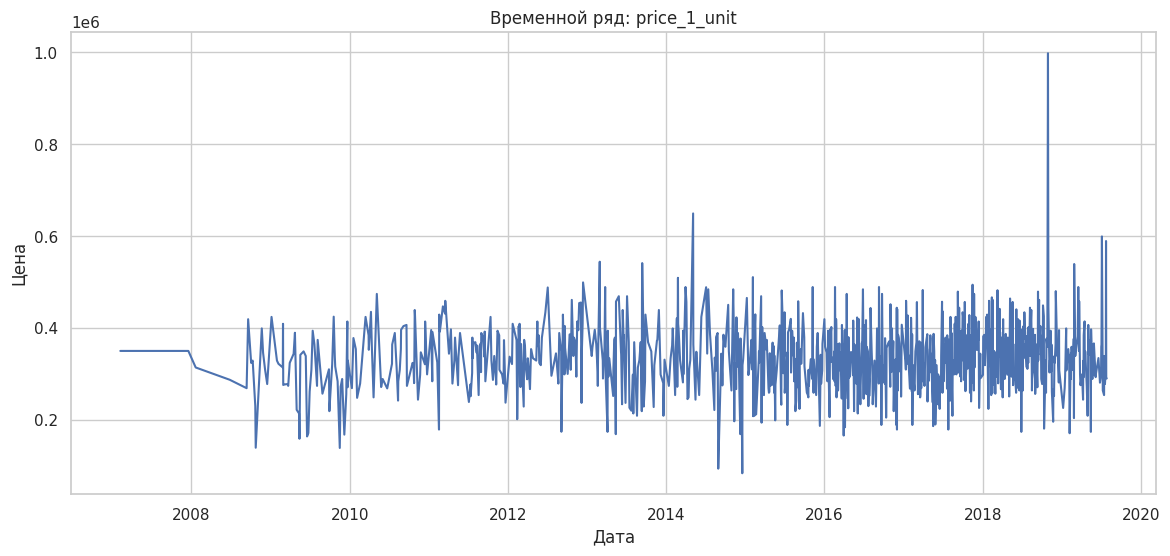

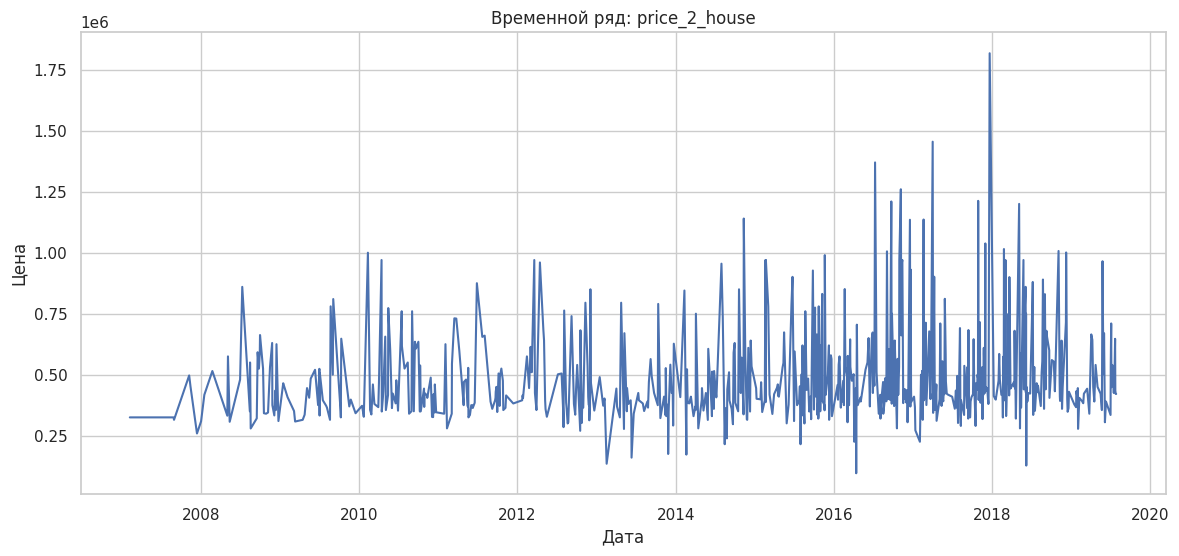

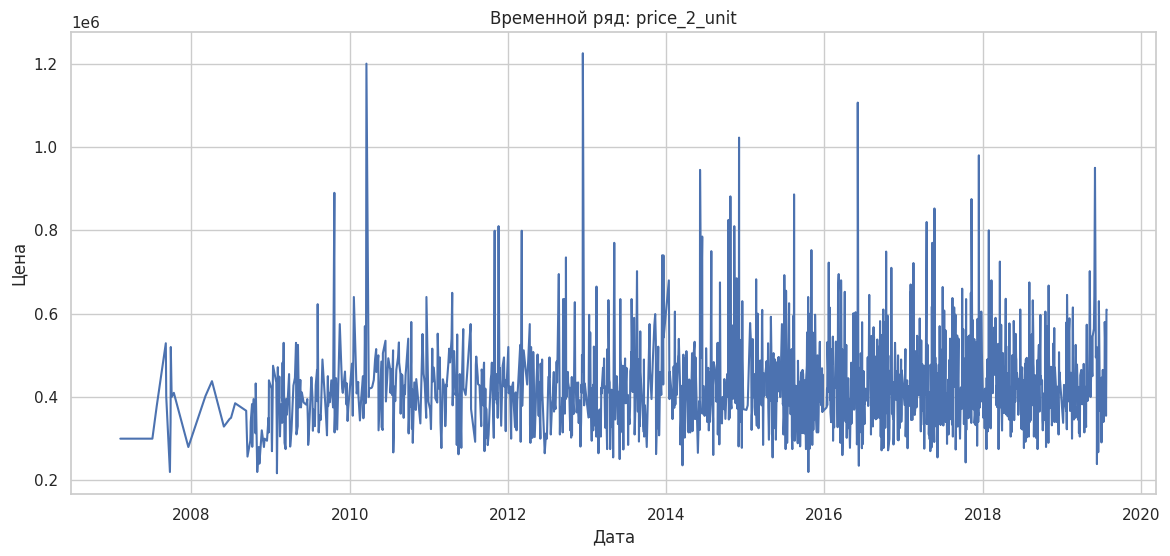

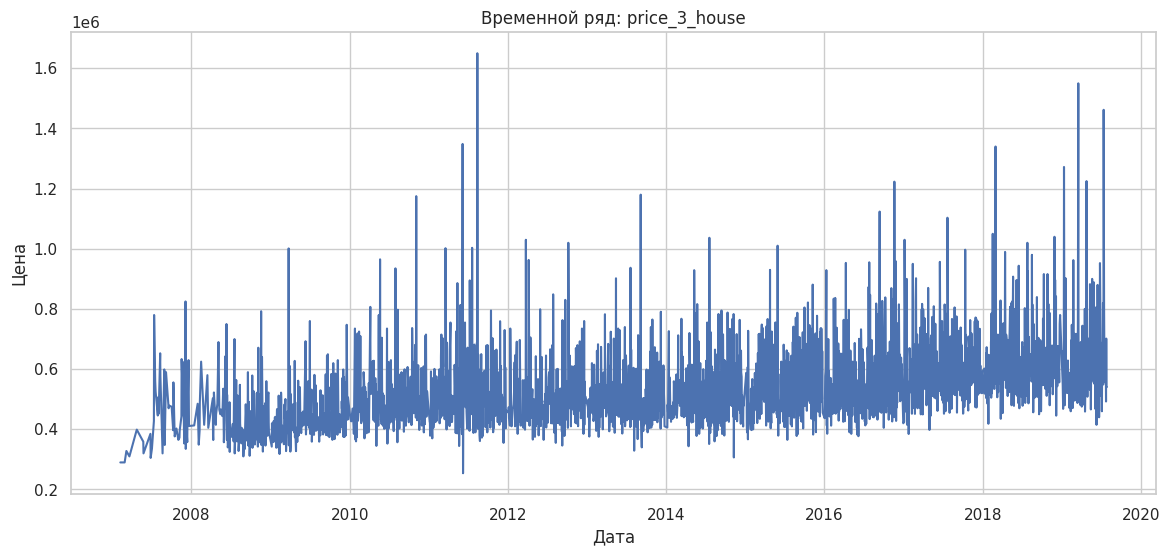

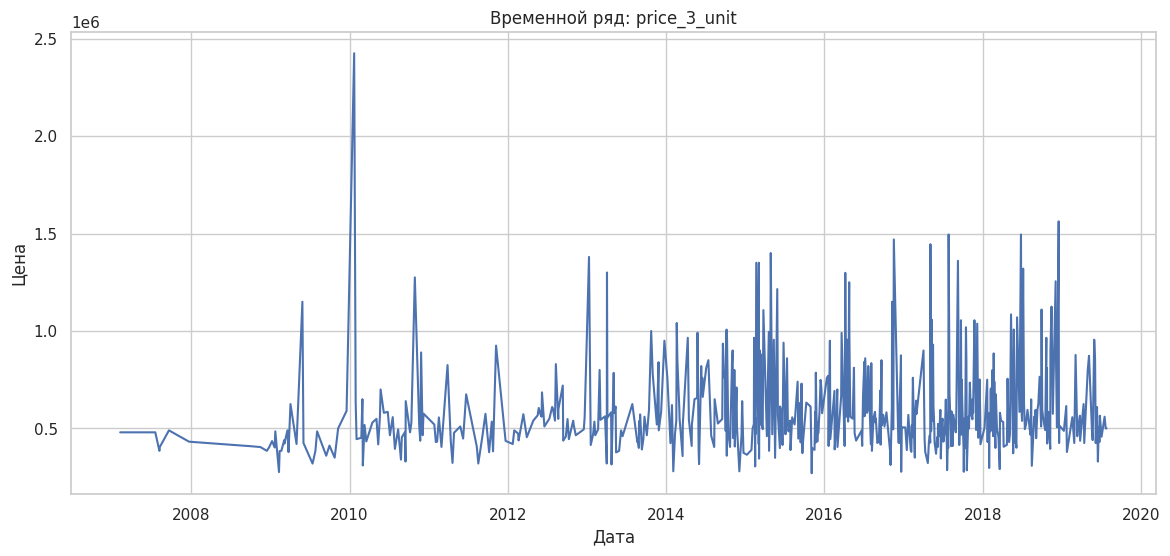

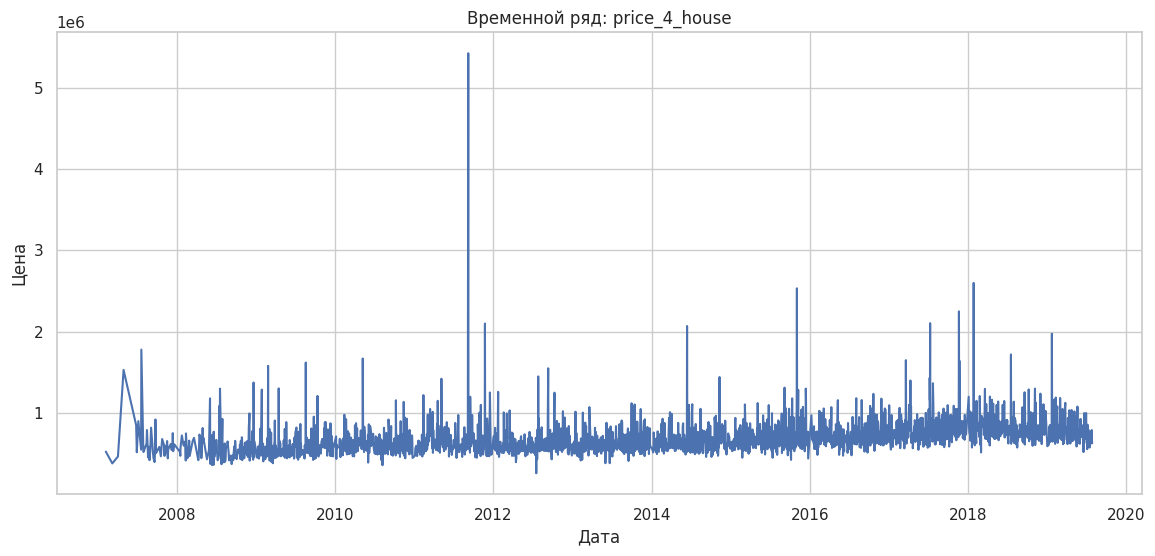

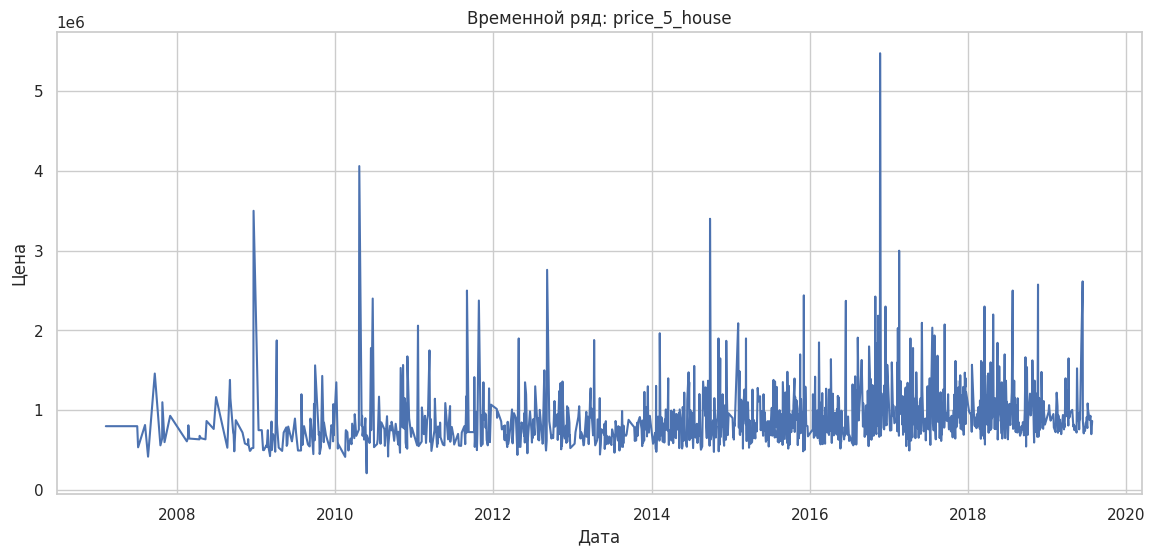

In [14]:
# Визуализация каждого параметра на отдельном графике
for col in all_ts_df.columns:
    if col == 'datesold':
        continue
    plt.figure(figsize=(14,6))
    sns.lineplot(data=all_ts_df, x='datesold', y=col)
    plt.title(f"Временной ряд: {col}")
    plt.xlabel("Дата")
    plt.ylabel("Цена")
    plt.savefig(f"images/time_series/{col}.png", dpi=200)
    plt.show()

По графикам видно что данные имеют высокий разброс значений, при этом для каждого параметра свойственно наличие пропусков в начале временного ряда и увеличений частоты показателей к концу периода

# 3) EDA

Определим скользящие статистики для 30 и 180 дней

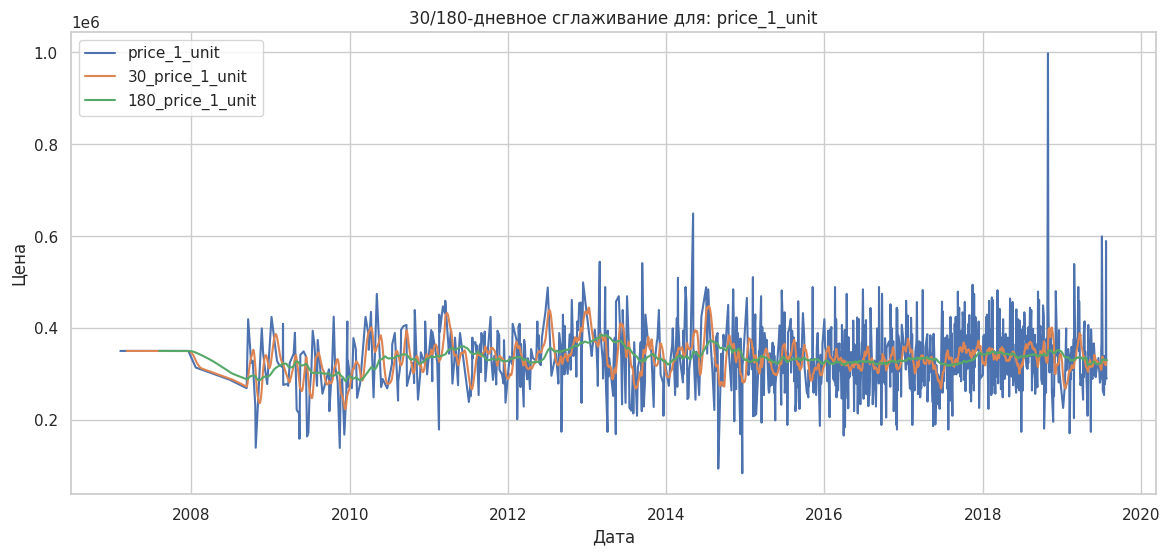

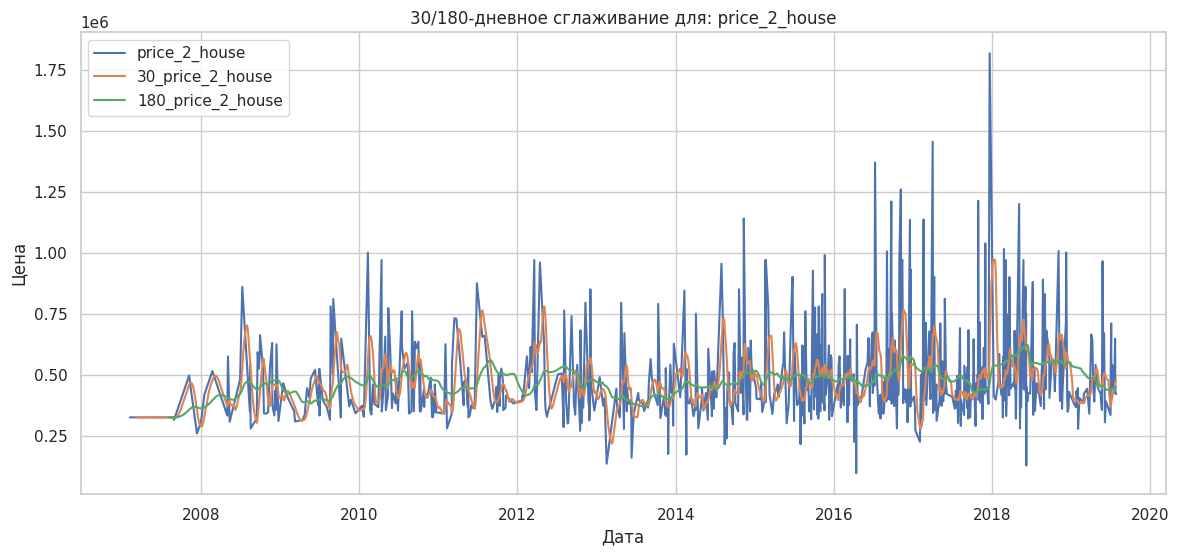

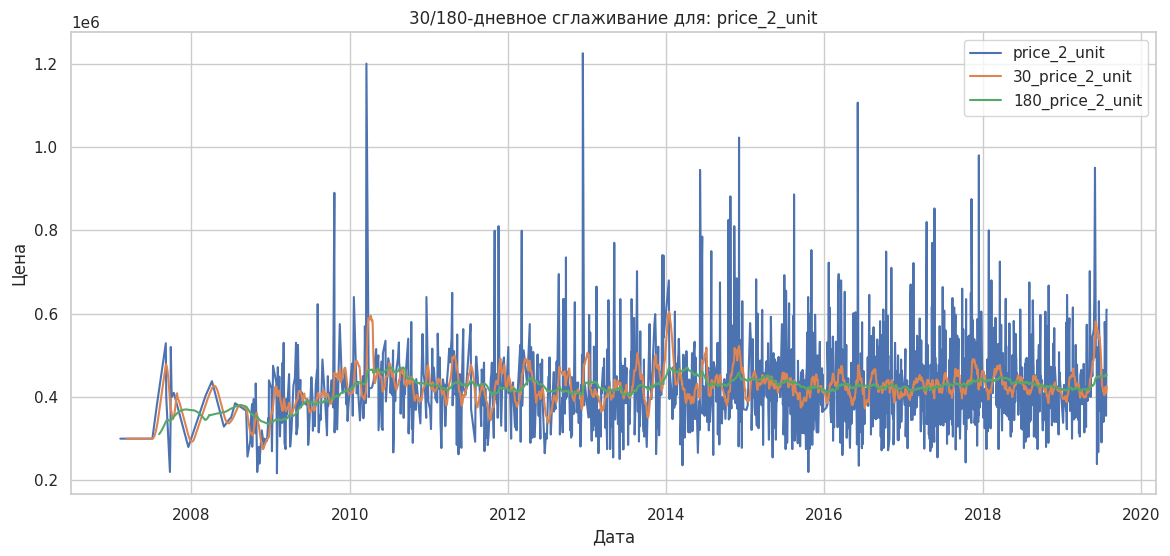

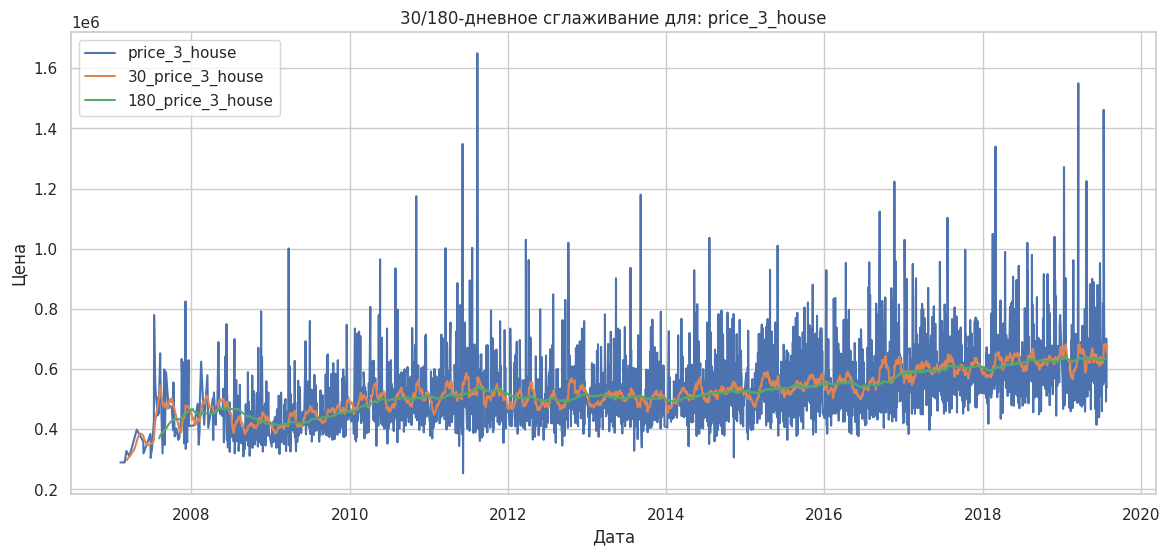

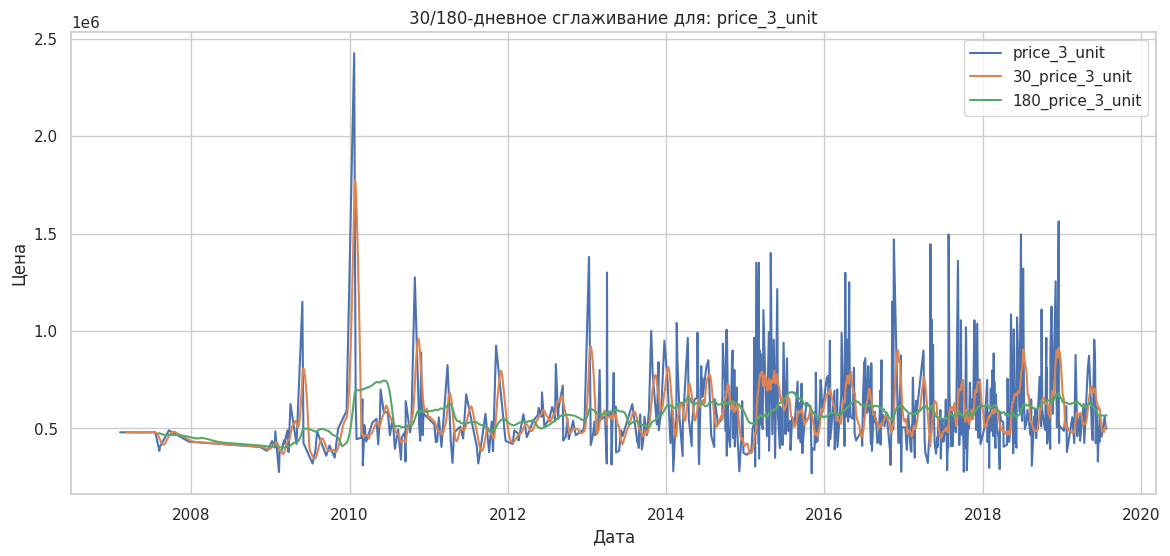

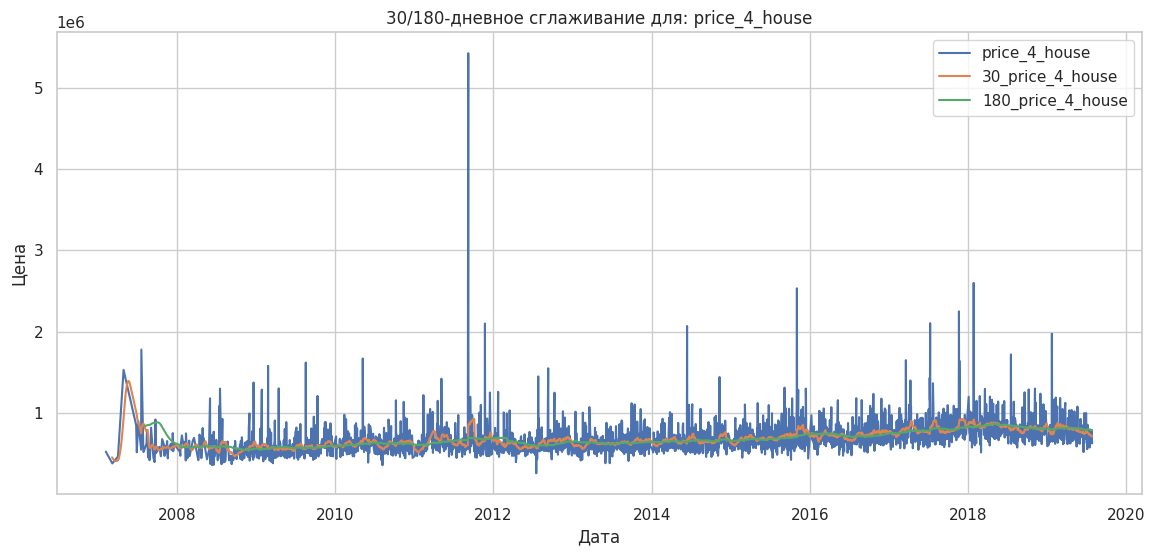

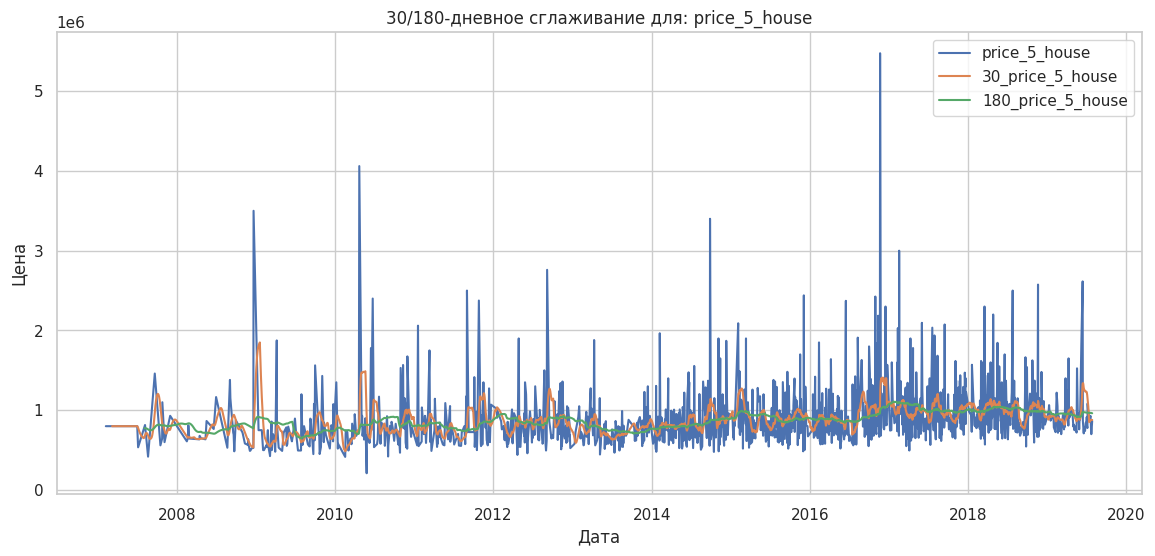

In [15]:
for col in all_ts_df.columns:
    if col == 'datesold':
        continue

    current_ts = all_ts_df.set_index('datesold')[col]

    plt.figure(figsize=(14,6))
    sns.lineplot(data=current_ts, label=col)
    sns.lineplot(current_ts.rolling(30).mean(), label=f"30_{col}")
    sns.lineplot(current_ts.rolling(180).mean(), label=f"180_{col}")
    plt.legend()
    plt.title(f"30/180-дневное сглаживание для: {col}")
    plt.xlabel("Дата")
    plt.ylabel("Цена")
    plt.savefig(f"images/rolling_mean/rolling_mean_{col}.png", dpi=200)
    plt.show()

Декомпозиция

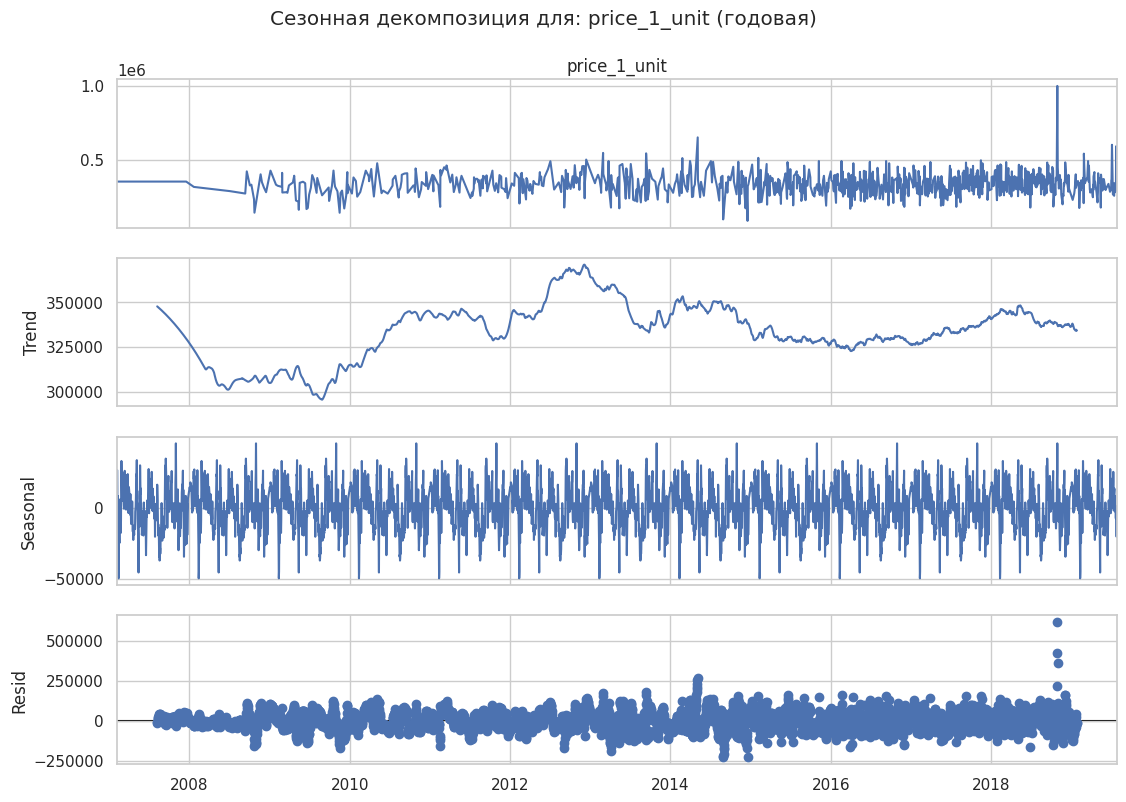

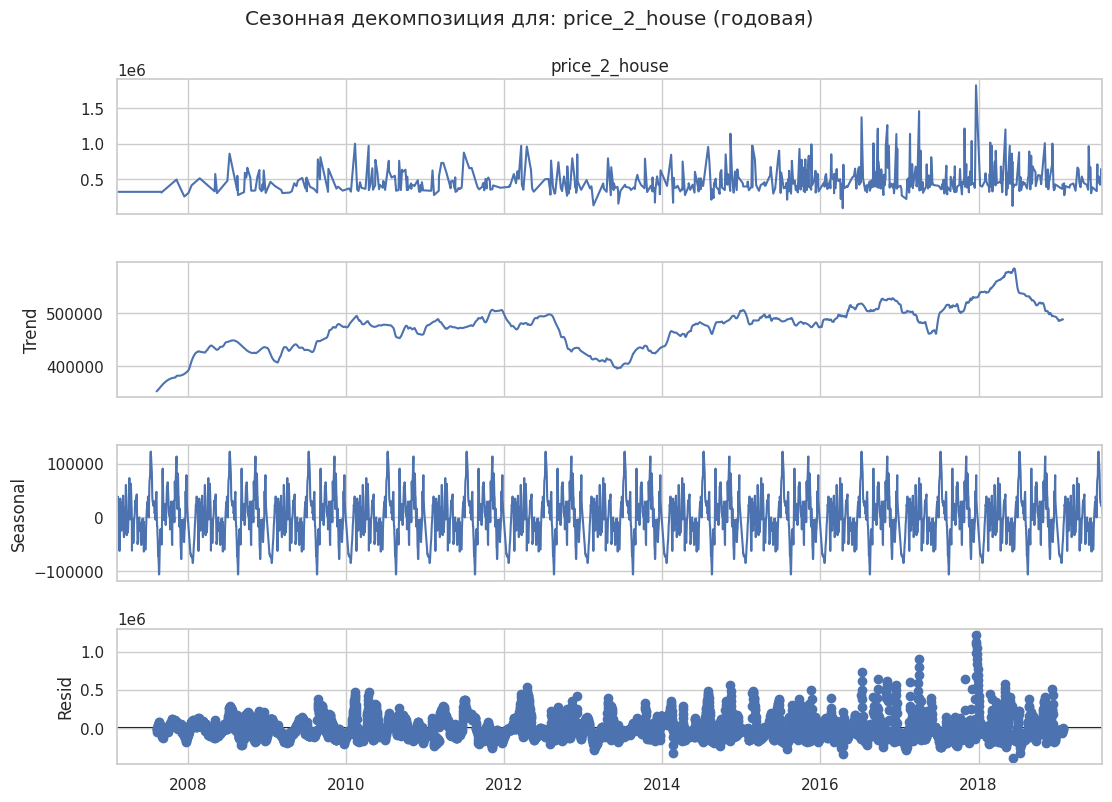

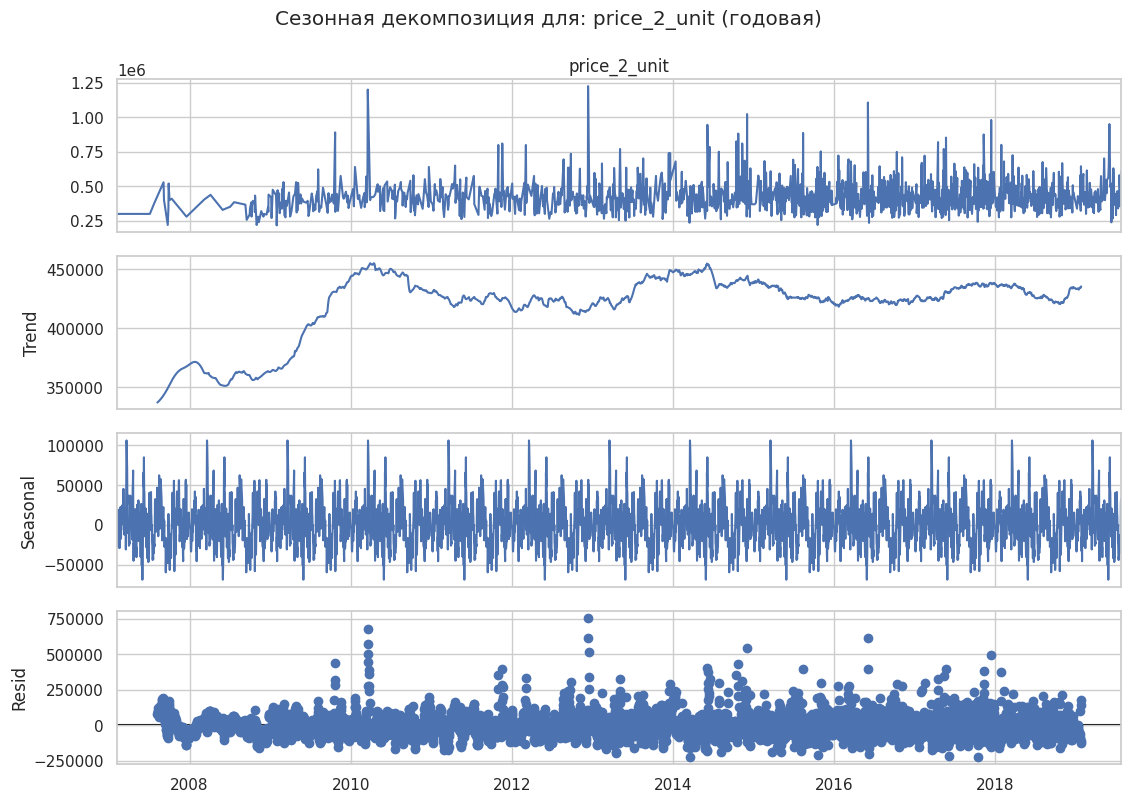

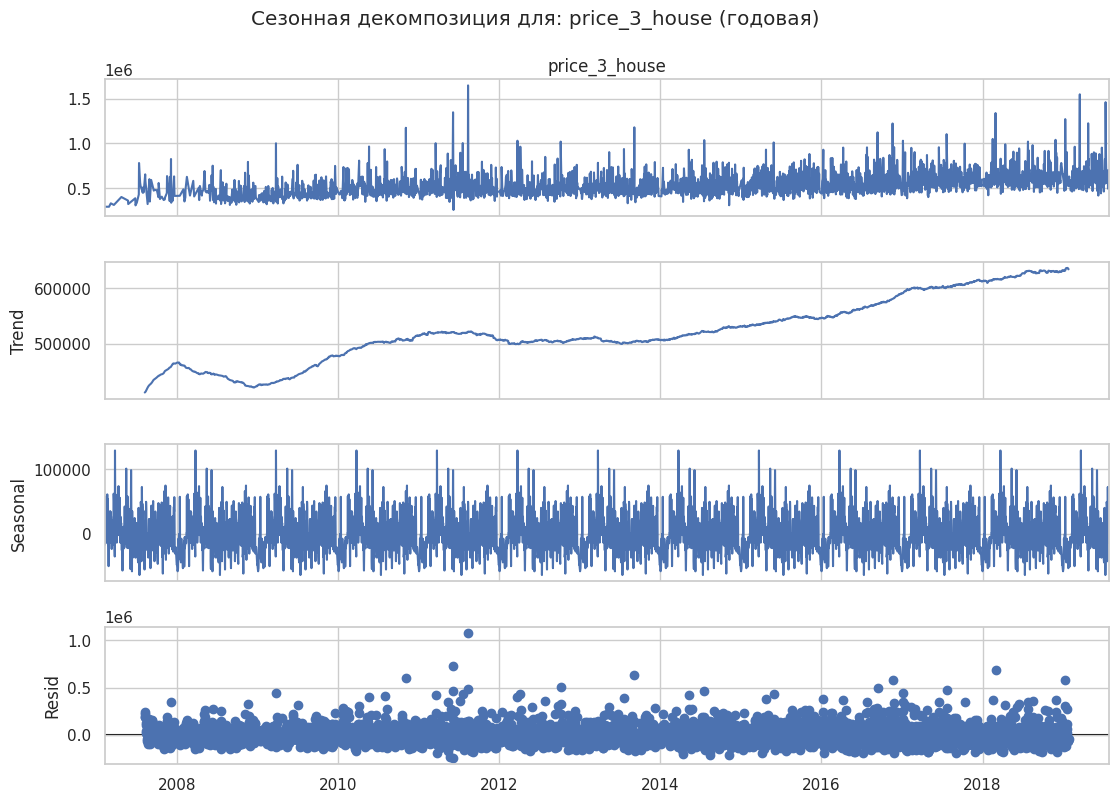

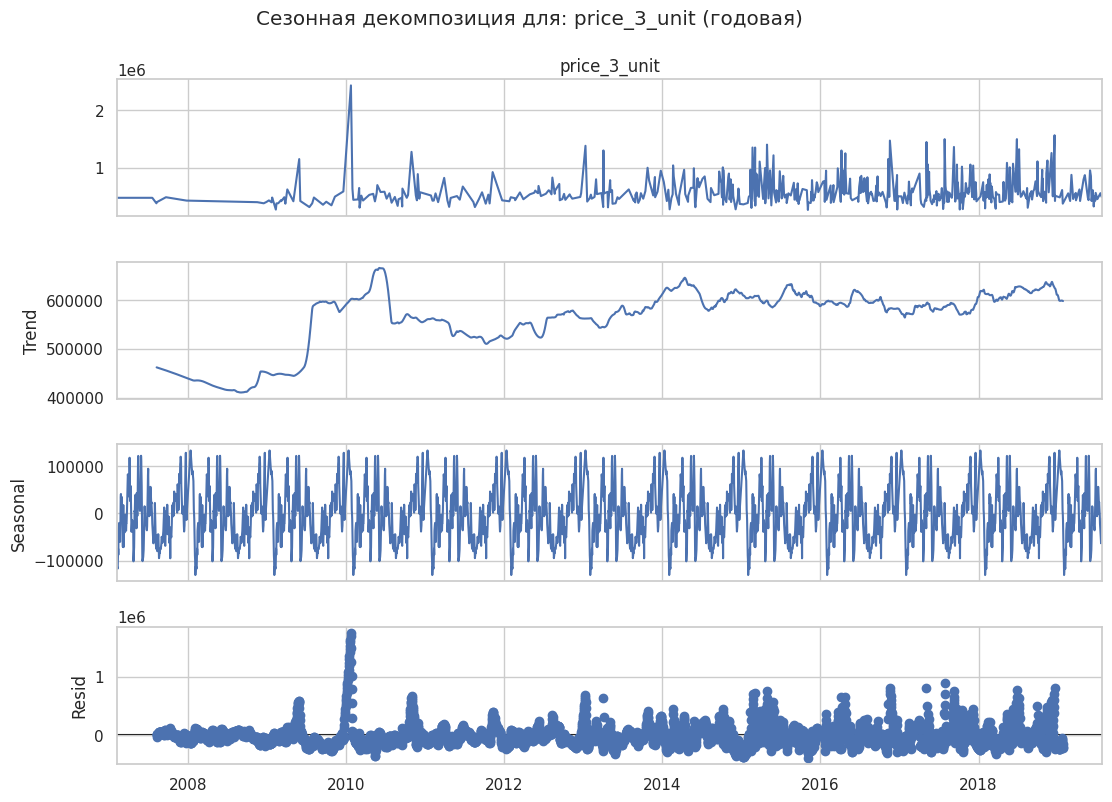

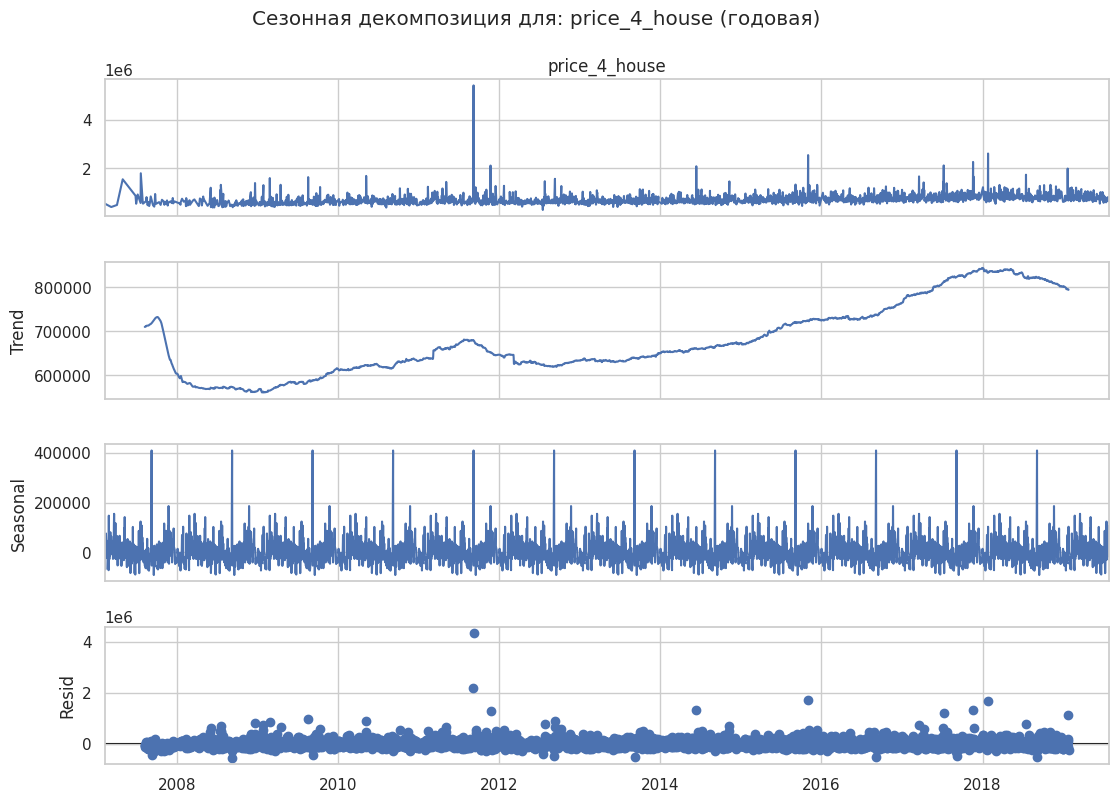

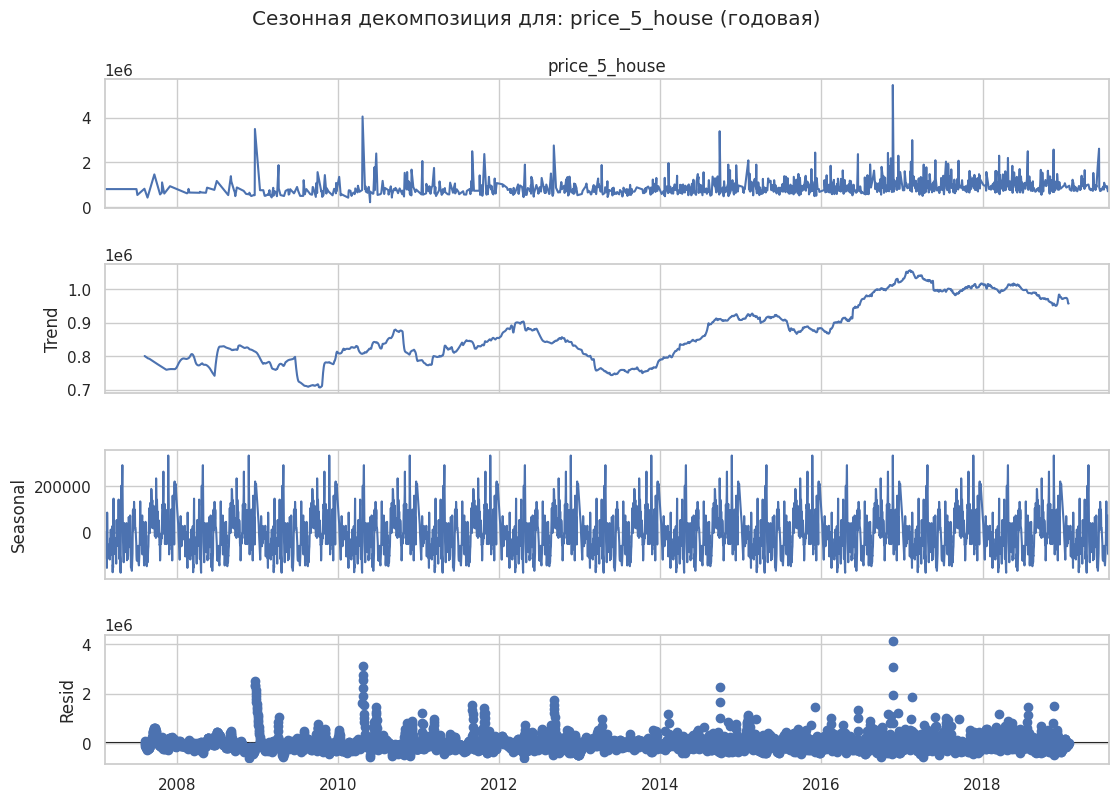

In [16]:
for col in all_ts_df.columns:
    if col == 'datesold':
        continue

    current_ts = all_ts_df.set_index('datesold')[col]

    decomp = seasonal_decompose(current_ts, model="additive", period=365)

    fig = decomp.plot()
    fig.set_size_inches(12, 8)
    plt.suptitle(f"Сезонная декомпозиция для: {col} (годовая)", y=1.02)
    plt.savefig(f"images/decomposition/decomposition_{col}.png", dpi=200)
    plt.show()

Во всех случаях наблюдается восходящий тренд и наличие сезонности, при этом дома с 4 и 5 спальнями имеют самый плавный тренд, что обусловлена относительно большим содержанием данных

Тесты стационарности (ADF, KPSS)

In [17]:
def adf_test_concise(s):
    res = adfuller(s.dropna())
    is_stationary = res[1] <= 0.05
    return {"ADF_p_value": res[1], "ADF_Stationary": is_stationary}

def kpss_test_concise(s):

    res = kpss(s.dropna(), nlags="auto")
    is_stationary = res[1] > 0.05
    return {"KPSS_p_value": res[1], "KPSS_Stationary": is_stationary}

all_stationarity_results = []
# Соберем показания в таблицу
for col in all_ts_df.columns:
    if col == 'datesold':
        continue

    current_ts = all_ts_df.set_index('datesold')[col]
    adf_res = adf_test_concise(current_ts)
    kpss_res = kpss_test_concise(current_ts)

    result_row = {"Series": col}
    result_row.update(adf_res)
    result_row.update(kpss_res)
    all_stationarity_results.append(result_row)

results_df = pd.DataFrame(all_stationarity_results)
display(results_df)

/tmp/ipython-input-3191329987.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(s.dropna(), nlags="auto")
/tmp/ipython-input-3191329987.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(s.dropna(), nlags="auto")
/tmp/ipython-input-3191329987.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(s.dropna(), nlags="auto")
/tmp/ipython-input-3191329987.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(s.dropna(), nlags="auto")
/tmp/ipython-input-3191329987.py

Series   ADF_p_value  ADF_Stationary  KPSS_p_value  KPSS_Stationary
0   price_1_unit  4.061647e-21            True      0.067508             True
1  price_2_house  1.741797e-20            True      0.010000            False
2   price_2_unit  5.739615e-20            True      0.010000            False
3  price_3_house  2.130621e-04            True      0.010000            False
4   price_3_unit  1.702976e-18            True      0.010000            False
5  price_4_house  4.520684e-09            True      0.010000            False
6  price_5_house  1.656791e-20            True      0.010000            False

Тесты стационарности говорят о том, что временные серии не стационарны

ACF / PACF

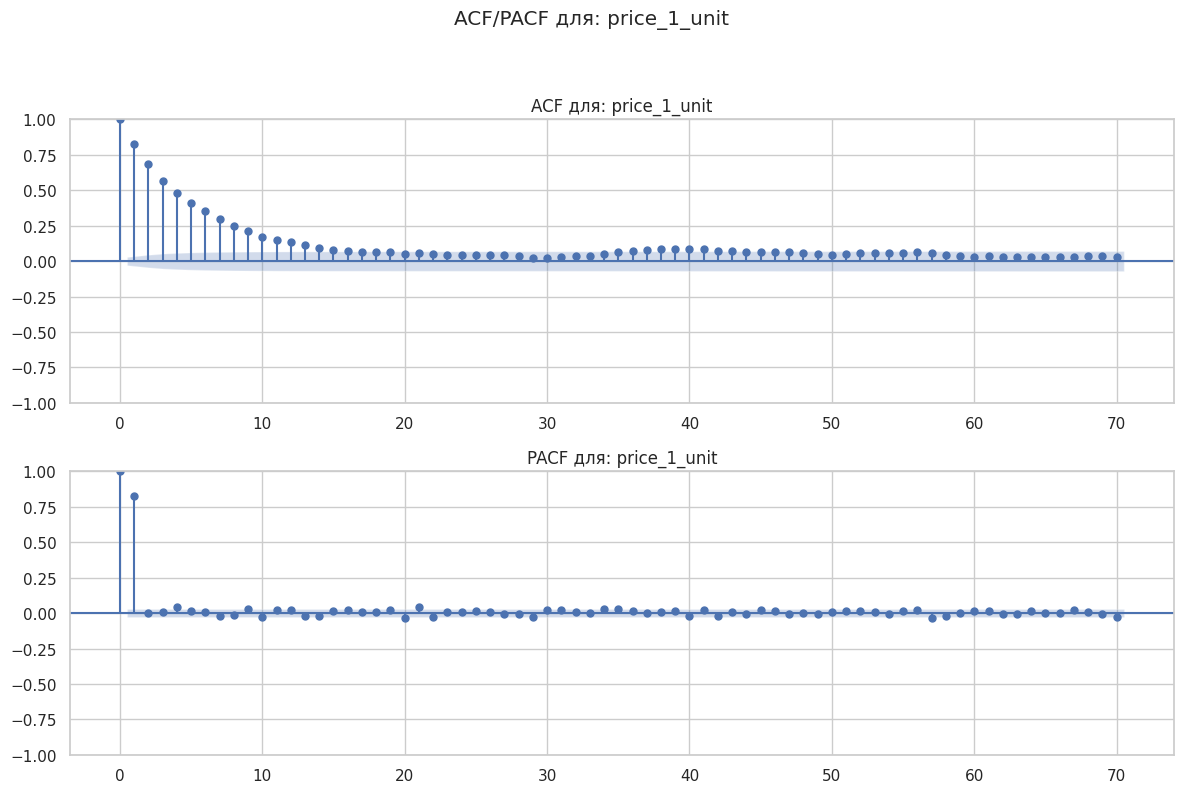

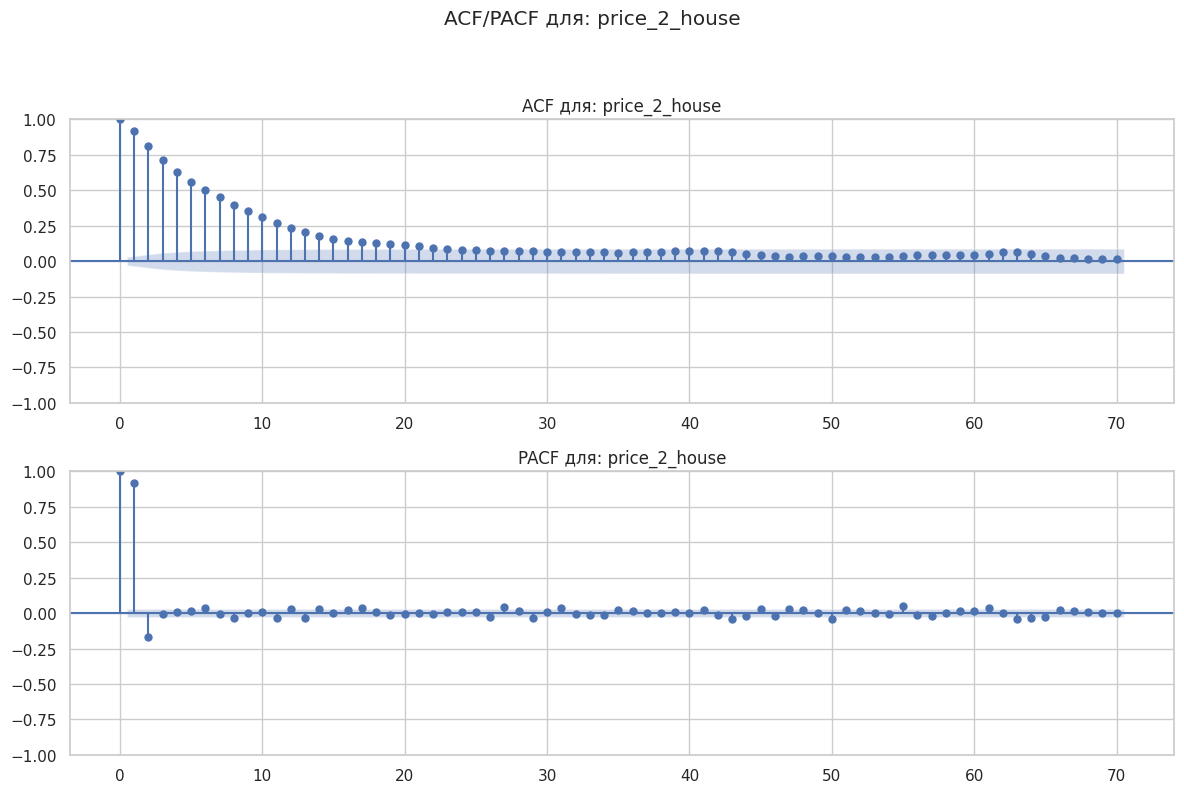

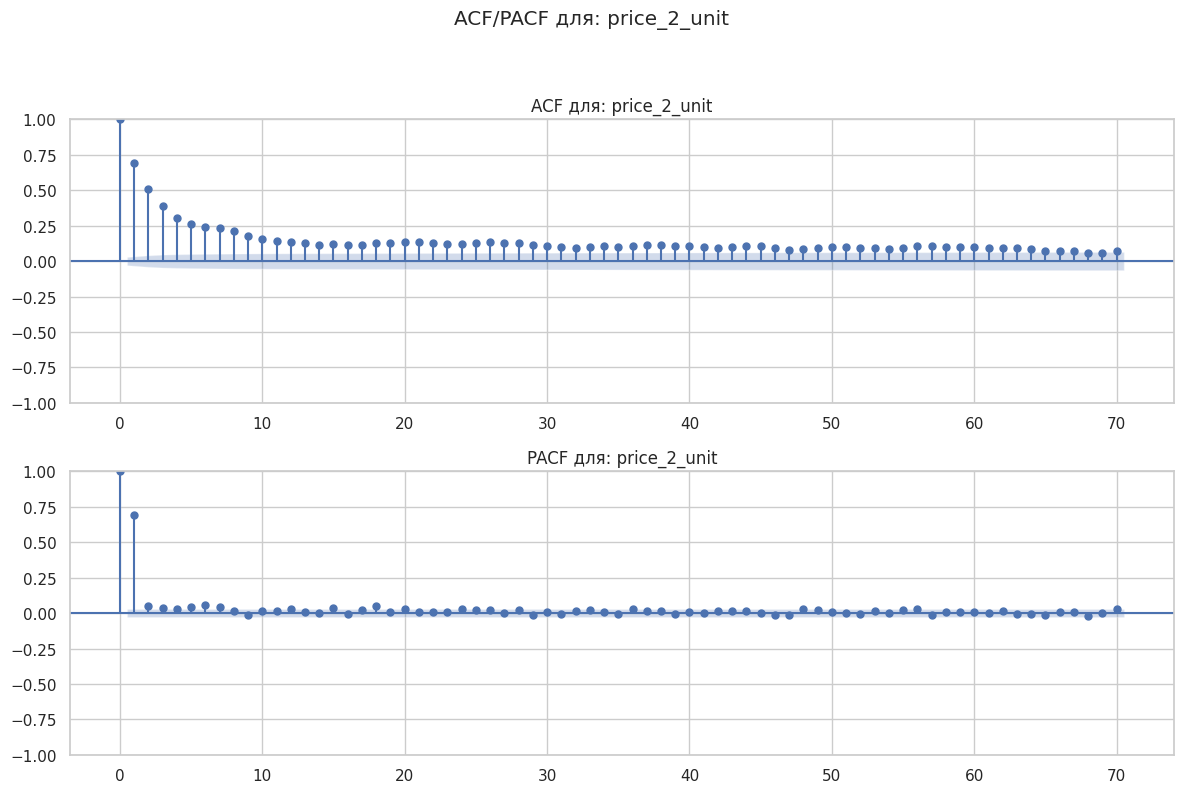

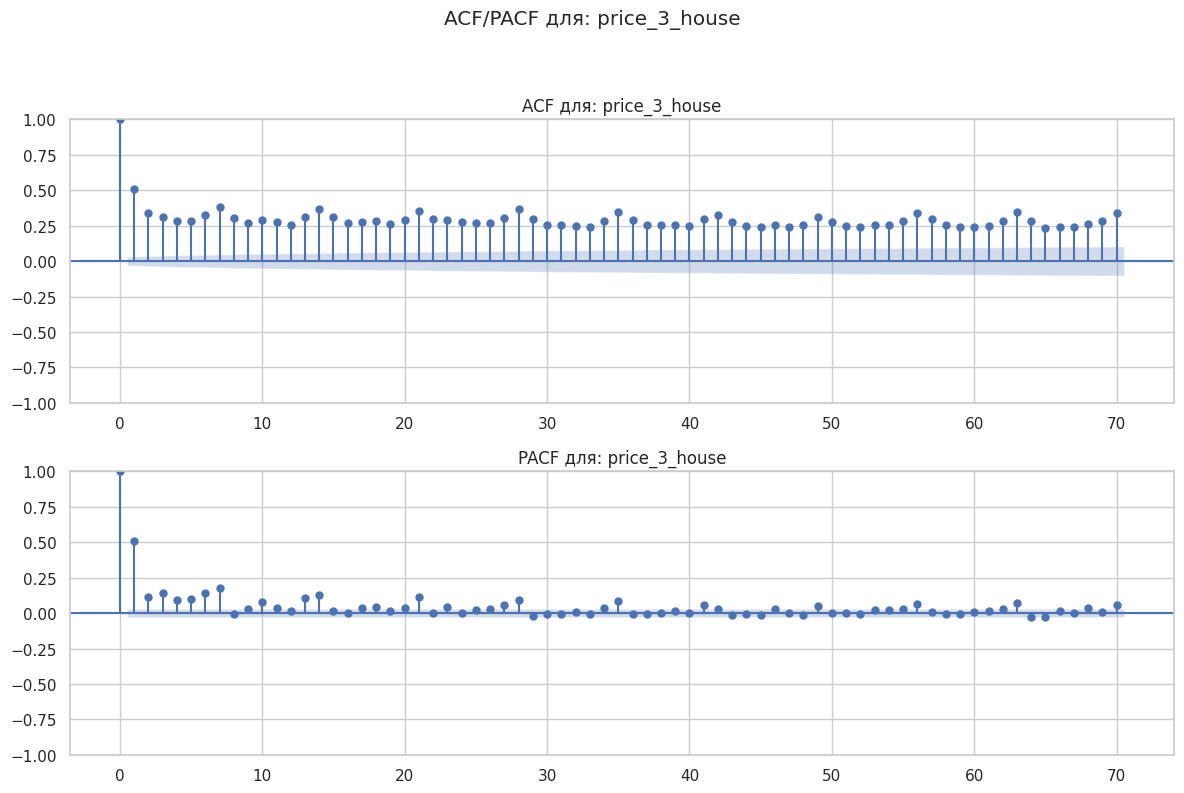

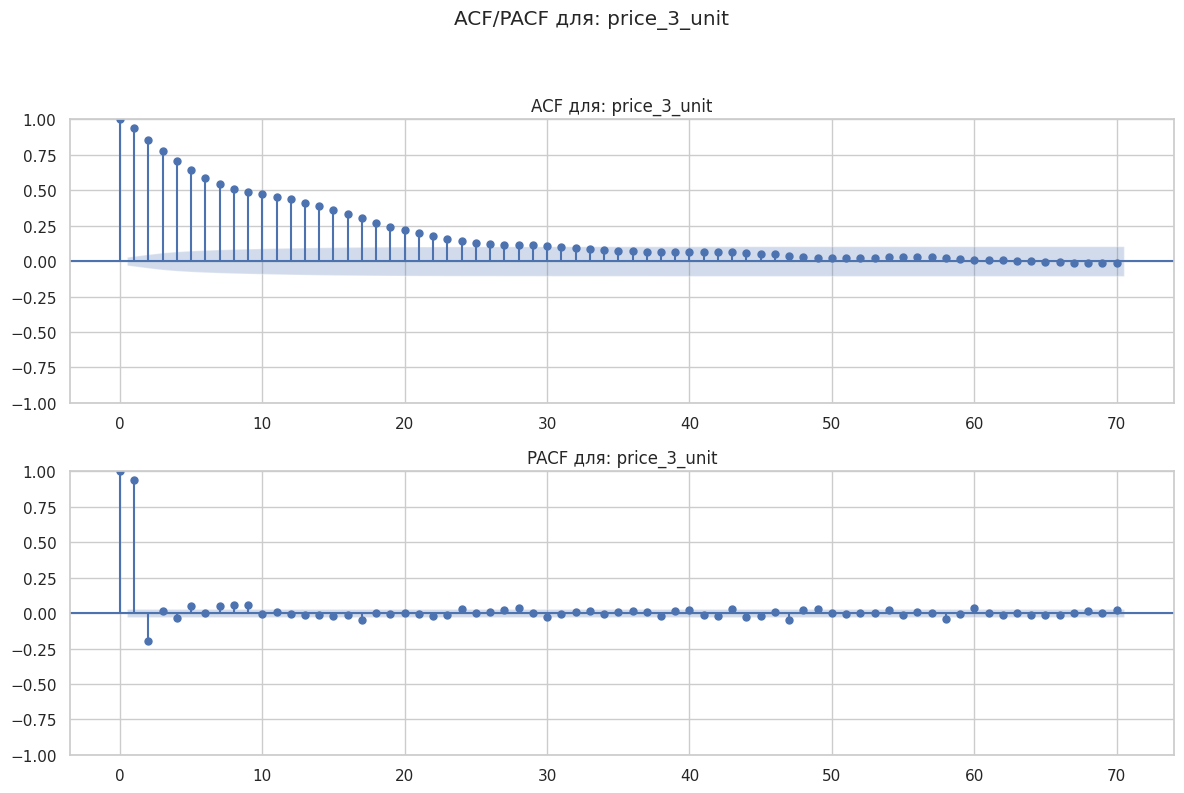

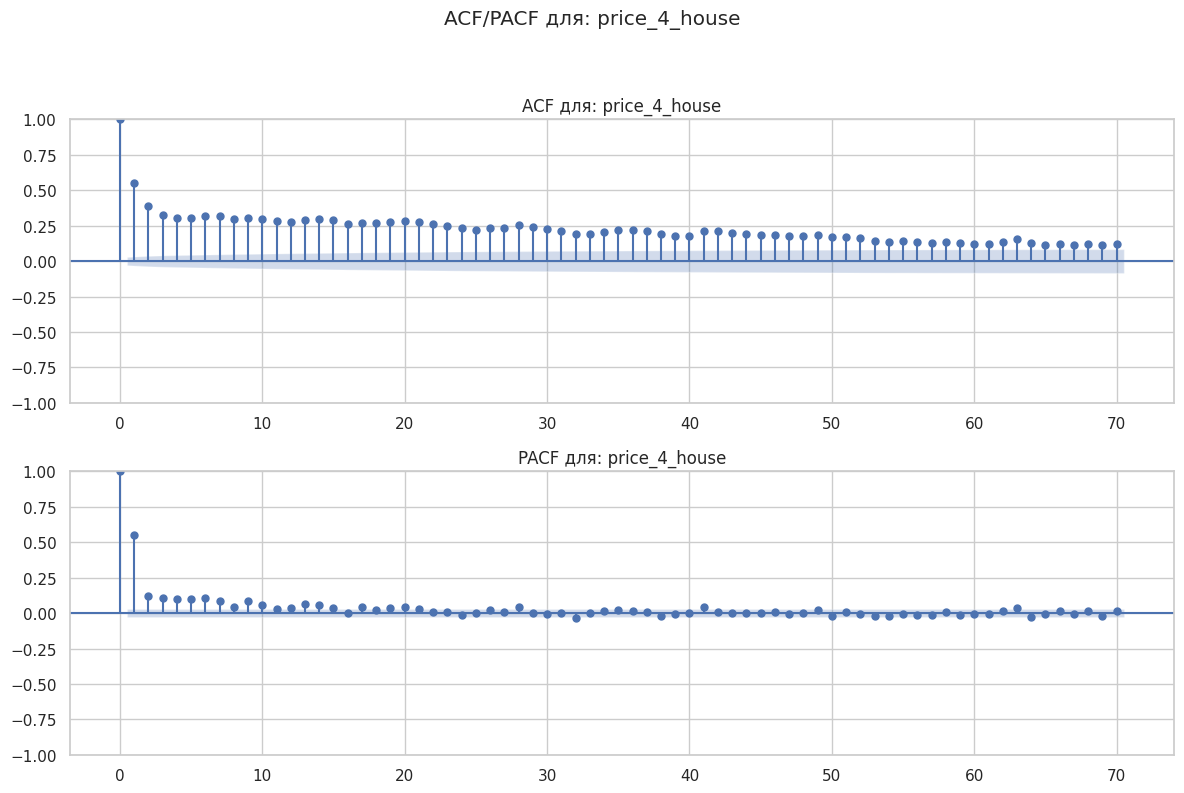

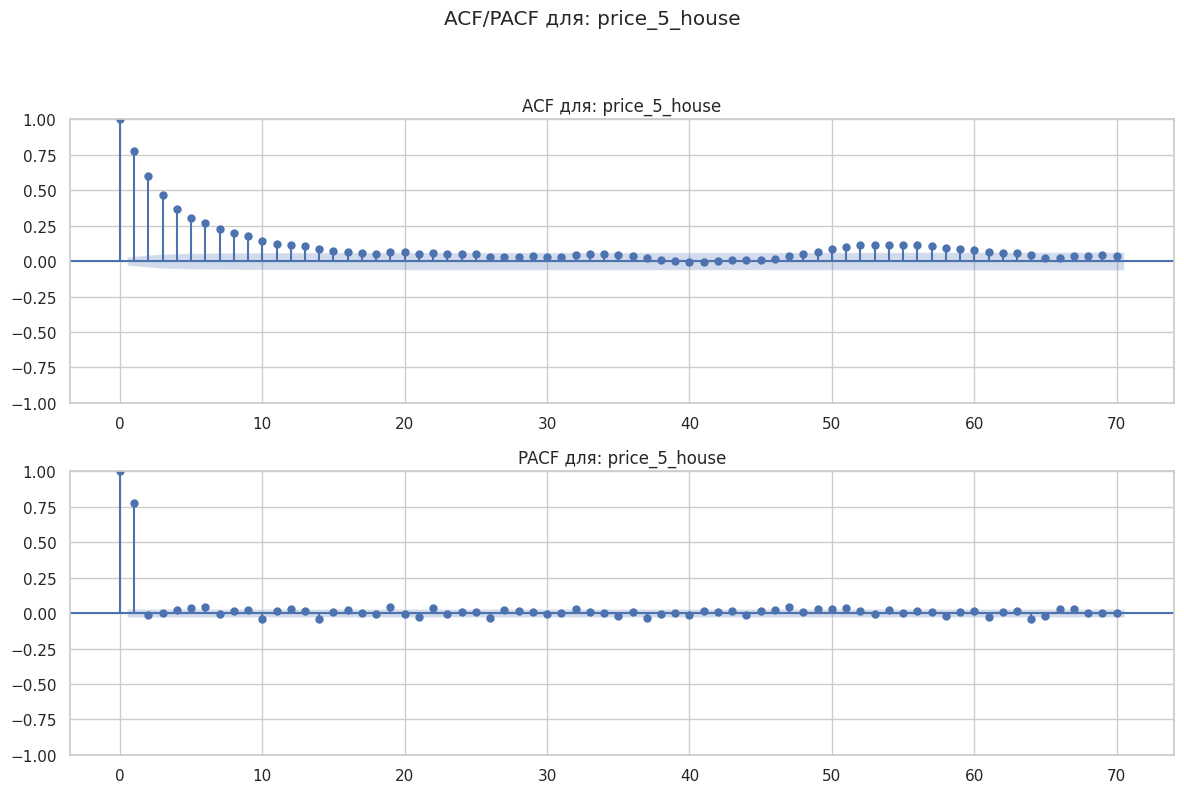

In [18]:
for col in all_ts_df.columns:
    if col == 'datesold':
        continue

    current_ts = all_ts_df.set_index('datesold')[col]

    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(current_ts, lags=70, ax=ax[0])
    ax[0].set_title(f'ACF для: {col}')
    plot_pacf(current_ts, lags=70, ax=ax[1], method='ywm')
    ax[1].set_title(f'PACF для: {col}')
    plt.suptitle(f"ACF/PACF для: {col}", y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.savefig(f"images/acf_pacf/acf_pacf_{col}.png", dpi=200)
    plt.show()

Для всех рядов наблюдается очень медленное убывание коэффициентов автокорреляции на графиках ACF. Это является сильным визуальным индикатором нестационарности временных рядов, что полностью согласуется с результатами тестов стационарности ADF и KPSS.

Значимые пики на первых нескольких лагах (например, 1, 2, 3 дня) как в ACF, так и в PACF показывают, что текущая цена сильно зависит от цен самых ближайших предыдущих дней.

На некоторых графиках(price_3_house и price_3_house) ACF и PACF могут наблюдаться всплески на лаге 7, что указывает на наличие недельной сезонности.

# 4) Подготовка к построению моделей прогнозирования

Функция для расчета показателей ошибок MAE, MAPE, RMSE

In [19]:
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'RMSE': rmse, 'MAE': mae, 'MAPE%': mape}

Установим значение разделения тренировочной и тестовой выборок

In [20]:
horizon = 90

Создадим признаки на основе лагов и экспоненциального скользящего среднего для более точного определения временных зависемостей

In [21]:
df_features_by_series = {}

lags = [1, 2, 3, 7, 14, 30, 90, 180, 365]

for col in all_ts_df.columns:
    if col == 'datesold':
        continue

    current_ts = all_ts_df.set_index('datesold')[col]
    df_feat = pd.DataFrame(current_ts)
    df_feat.columns = ['y']

    for lag in lags:
        df_feat[f'lag_{lag}'] = current_ts.shift(lag)

    # Добавьте экспоненциальные скользящие средние (EMA), чтобы отразить последние тенденции
    df_feat['ema_10'] = current_ts.ewm(span=10, adjust=False).mean()
    df_feat['ema_30'] = current_ts.ewm(span=30, adjust=False).mean()
    df_feat['ema_60'] = current_ts.ewm(span=60, adjust=False).mean()

    # Отбросим NaN, введенные в результате расчетов с запаздыванием и EMA
    df_feat.dropna(inplace=True)
    # Создадим словарь датафреймов с лагами для каждого параметра
    df_features_by_series[col] = df_feat

In [22]:
display(df_features_by_series['price_1_unit'].head())

y          lag_1          lag_2          lag_3  \
datesold                                                                 
2008-02-07  312129.870130  312298.701299  312467.532468  312636.363636   
2008-02-08  311961.038961  312129.870130  312298.701299  312467.532468   
2008-02-09  311792.207792  311961.038961  312129.870130  312298.701299   
2008-02-10  311623.376623  311792.207792  311961.038961  312129.870130   
2008-02-11  311454.545455  311623.376623  311792.207792  311961.038961   

                    lag_7         lag_14         lag_30    lag_90   lag_180  \
datesold                                                                      
2008-02-07  313311.688312  314493.506494  328764.705882  351000.0  351000.0   
2008-02-08  313142.857143  314324.675325  327705.882353  351000.0  351000.0   
2008-02-09  312974.025974  314155.844156  326647.058824  351000.0  351000.0   
2008-02-10  312805.194805  313987.012987  325588.235294  351000.0  351000.0   
2008-02-11  312636.363636  313818.181818  324529.411765  351000.0  351000.0   

             lag_365         ema_10         ema_30         ema_60  
datesold                                                           
2008-02-07  351000.0  313021.582739  318219.280496  326301.650520  
2008-02-08  351000.0  312828.756598  317815.522977  325831.466535  
2008-02-09  351000.0  312640.293179  317426.921998  325371.162969  
2008-02-10  351000.0  312455.399260  317052.499716  324920.415876  
2008-02-11  351000.0  312273.425840  316691.341376  324478.911928

# 5) Прогнозирование

Построим прогноз при помощи моделей: AutoARIMA, RandomForestRegretion, LightGBM, XGBoost, LSTM

**Модель AutoARIMA**

Обучение модели AutoARIMA для прогнозирования временного ряда. Будем использовать "m=7", представляющее еженедельную сезонность.


In [23]:
# Солварь для хранения показателей ошибок
all_arima_metrics_per_series = {}

start_time = time.time()

for col in all_ts_df.columns:
    if col == 'datesold':
        continue

    current_ts = all_ts_df.set_index('datesold')[col]
    # Определим обучающие и тестовые данные
    current_train = current_ts.iloc[:-horizon]
    current_test  = current_ts.iloc[-horizon:]

    # Установка параметров для обучения
    model_arima = pm.auto_arima(current_train, seasonal=True, m=7, stepwise=True,
                                max_p=5, max_q=5, max_P=2, max_Q=2,
                                suppress_warnings=True, trace=False,
                                error_action='ignore',
                                n_jobs=-1)

    # Генерация прогноза
    arima_pred = pd.Series(model_arima.predict(n_periods=horizon), index=current_test.index)

    # Расчет метрик
    arima_metrics = calculate_metrics(current_test, arima_pred)
    all_arima_metrics_per_series[col] = arima_metrics

    # Сохранение модели и прогноза
    joblib.dump(model_arima, f'models/auto_arima_model/auto_arima_model_{col}.pkl')
    arima_pred.to_csv(f'results/auto_arima_predictions/auto_arima_predictions_{col}.csv')

cell_total_time_arima = time.time() - start_time

In [24]:
print(f"Время прогнозирования: {cell_total_time_arima/60:.2f} minuts")

Время прогнозирования: 79.43 minuts


**Модель Random Forest**

Обучение модели Random Forest для прогнозирования временного ряда.


In [36]:
all_rf_metrics_per_series = {}

start_time = time.time()

# Словарь для данных прогнозов для последующего построения графика.
all_rf_predictions = {}

for col, df_feat in df_features_by_series.items():

    X = df_feat.drop('y', axis=1)
    y = df_feat['y']

    # Определим тестовые данные
    current_ts = all_ts_df.set_index('datesold')[col]
    current_test_ts = current_ts.iloc[-horizon:]

    # Определите дату окончания тренировочного цикла в df_feat
    train_end_date_for_rf = current_test_ts.index.min() - pd.Timedelta(days=1)

    # Разделите X и y для обучения и тестирования
    X_train = X.loc[X.index <= train_end_date_for_rf]
    y_train = y.loc[y.index <= train_end_date_for_rf]

    # Возьмем даты, присутствующие как в current_test_ts.index, так и в X.index
    common_test_index = current_test_ts.index.intersection(X.index)
    X_test  = X.loc[common_test_index]
    y_test  = y.loc[common_test_index]

    # Масштабирование
    scaler = StandardScaler()

    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # Создание и обучение RandomForestRegressor с установленными параметрами
    model_rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=18,
        min_samples_split=8,
        min_samples_leaf=2,
        random_state=RND
    )
    model_rf.fit(X_train_s, y_train)

    # Прогнозирование на тестовом наборе
    rf_pred_raw = model_rf.predict(X_test_s)
    rf_pred = pd.Series(rf_pred_raw, index=common_test_index)

    # Расчет метрик
    rf_metrics = calculate_metrics(y_test, rf_pred)
    all_rf_metrics_per_series[col] = rf_metrics

    # Сохранение обученной модели и прогноза
    joblib.dump(model_rf, f'models/rf_model/rf_model_{col}.joblib')
    rf_pred.to_csv(f'results/rf_predictions/rf_predictions_{col}.csv')

    all_rf_predictions[col] = rf_pred

cell_total_time_rfr = time.time() - start_time

In [37]:
print(f"Время прогнозирования: {cell_total_time_rfr/60:.2f} minuts")

Время прогнозирования: 4.17 minuts


**Модель LGBM**

Обучение модели LGBM для прогнозирования временного ряда.


In [27]:
all_lgbm_metrics_per_series = {}
all_lgbm_predictions = {}

start_time = time.time()

for col, df_feat in df_features_by_series.items():

    X = df_feat.drop('y', axis=1)
    y = df_feat['y']

    current_ts = all_ts_df.set_index('datesold')[col]
    current_test_ts = current_ts.iloc[-horizon:]

    train_end_date_for_lgbm = current_test_ts.index.min() - pd.Timedelta(days=1)

    X_train = X.loc[X.index <= train_end_date_for_lgbm]
    y_train = y.loc[y.index <= train_end_date_for_lgbm]

    common_test_index = current_test_ts.index.intersection(X.index)
    X_test  = X.loc[common_test_index]
    y_test  = y.loc[common_test_index]

    scaler = StandardScaler()

    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)
    # Создание и обучение LGBMR с установленными параметрами
    lgbm_model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RND,
        force_col_wise=True,
        verbose=-1
    )

    lgbm_model.fit(X_train_s, y_train)

    lgbm_pred = pd.Series(lgbm_model.predict(X_test_s), index=common_test_index)

    lgbm_metrics = calculate_metrics(y_test, lgbm_pred)
    all_lgbm_metrics_per_series[col] = lgbm_metrics

    joblib.dump(lgbm_model, f"models/lgbm_model/lgbm_model_{col}.joblib")
    lgbm_pred.to_csv(f"results/lgbm_predictions/lgbm_predictions_{col}.csv")

    all_lgbm_predictions[col] = lgbm_pred

cell_total_time_lgbm = time.time() - start_time

In [28]:
print(f"Время прогнозирования: {cell_total_time_lgbm:.2f} seconds")

Время прогнозирования: 13.44 seconds


**Модель XGB**

Обучение модели XGB для прогнозирования временного ряда.

In [29]:
all_xgb_metrics_per_series = {}
all_xgb_predictions = {}

start_time = time.time()

for col, df_feat in df_features_by_series.items():

    X = df_feat.drop('y', axis=1)
    y = df_feat['y']

    current_ts = all_ts_df.set_index('datesold')[col]
    current_test_ts = current_ts.iloc[-horizon:]

    train_end_date_for_xgb = current_test_ts.index.min() - pd.Timedelta(days=1)

    X_train = X.loc[X.index <= train_end_date_for_xgb]
    y_train = y.loc[y.index <= train_end_date_for_xgb]

    common_test_index = current_test_ts.index.intersection(X.index)
    X_test  = X.loc[common_test_index]
    y_test  = y.loc[common_test_index]

    scaler = StandardScaler()

    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    xgb_model = XGBRegressor(
        n_estimators=800,
        learning_rate=0.02,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=RND
    )

    xgb_model.fit(X_train_s, y_train)

    xgb_pred = pd.Series(xgb_model.predict(X_test_s), index=common_test_index)

    xgb_metrics = calculate_metrics(y_test, xgb_pred)
    all_xgb_metrics_per_series[col] = xgb_metrics

    joblib.dump(xgb_model, f"models/xgb_model/xgb_model_{col}.joblib")
    xgb_pred.to_csv(f"results/xgb_predictions/xgb_predictions_{col}.csv")

    all_xgb_predictions[col] = xgb_pred

cell_total_time_xgb = time.time() - start_time

In [30]:
print(f"Время прогнозирования: {cell_total_time_xgb:.2f} seconds")

Время прогнозирования: 21.09 seconds


**Модель LSTM**

Обучение модели нейронной сети LSTM для прогнозирования временного ряда.


In [31]:
start_time = time.time()

# функция для обучения модели
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

all_lstm_metrics_per_series = {}
all_lstm_predictions = {}

for col in all_ts_df.columns:
    if col == 'datesold':
        continue

    current_ts = all_ts_df.set_index('datesold')[col]
    current_train_ts = current_ts.iloc[:-horizon]
    current_test_ts = current_ts.iloc[-horizon:]

    # Масштабирвание
    scaler = MinMaxScaler(feature_range=(0, 1))

    train_scaled = scaler.fit_transform(current_train_ts.values.reshape(-1, 1))
    test_scaled = scaler.transform(current_test_ts.values.reshape(-1, 1))

    # Зададим количество дней на которые будет оираться модель при прогнозировании
    look_back = 30

    X_train_lstm, y_train_lstm = create_sequences(train_scaled, look_back)
    X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)

    # Создаем последовательности для тестирования
    last_look_back_train = train_scaled[-look_back:]
    extended_test_data_for_sequences = np.concatenate((last_look_back_train, test_scaled))
    X_test_lstm, y_test_lstm = create_sequences(extended_test_data_for_sequences, look_back)
    X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

    # Определение и компиляция модели LSTM
    model_lstm = Sequential()
    model_lstm.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')

    model_lstm.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=32, verbose=0)

    lstm_predictions_scaled = model_lstm.predict(X_test_lstm, verbose=0)

    # Прогнозы обратного преобразования и фактические тестовые значения
    lstm_pred_raw = scaler.inverse_transform(lstm_predictions_scaled)
    lstm_actual_raw = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

    # Преобразование в серию Pandas с правильным индексом
    lstm_pred = pd.Series(lstm_pred_raw.flatten(), index=current_test_ts.index)
    lstm_actual = pd.Series(lstm_actual_raw.flatten(), index=current_test_ts.index)

    lstm_metrics = calculate_metrics(lstm_actual, lstm_pred)
    all_lstm_metrics_per_series[col] = lstm_metrics

    # Сохраняем модель в формате .keras
    model_lstm.save(f'models/lstm_model/lstm_model_{col}.keras')
    lstm_pred.to_csv(f'results/lstm_predictions/lstm_predictions_{col}.csv')

    all_lstm_predictions[col] = lstm_pred

cell_total_time_lstm = time.time() - start_time

In [32]:
print(f"Время прогнозирования: {cell_total_time_lstm/60:.2f} minuts")

Время прогнозирования: 25.60 minuts


# 6) Сравнение моделей

Определим показания моделей и выберем лучшую

Консолидируем все показатели для сравнения

In [38]:
all_results_df_list = []

# Добавим показния ошибок каждой модели
all_results_df_list.append(pd.DataFrame(all_arima_metrics_per_series).T.assign(Model='AutoARIMA'))
all_results_df_list.append(pd.DataFrame(all_rf_metrics_per_series).T.assign(Model='RandomForest'))
all_results_df_list.append(pd.DataFrame(all_lgbm_metrics_per_series).T.assign(Model='LightGBM'))
all_results_df_list.append(pd.DataFrame(all_xgb_metrics_per_series).T.assign(Model='XGBoost'))
all_results_df_list.append(pd.DataFrame(all_lstm_metrics_per_series).T.assign(Model='LSTM'))

final_comparison_df = pd.concat(all_results_df_list)
final_comparison_df.index.name = 'Series'
final_comparison_df = final_comparison_df.reset_index().set_index(['Series','Model', ])

final_comparison_df.to_csv("results/all_model_metrics.csv")

In [39]:
display(final_comparison_df.sort_values(by=["Series",'MAPE%']))

RMSE            MAE      MAPE%
Series        Model                                                
price_1_unit  LightGBM       39577.479535   24686.793181   7.480489
              XGBoost        41544.605838   24644.885780   7.647263
              RandomForest   49065.195201   25899.529655   7.693785
              LSTM           54481.812850   26511.850289   7.801763
              AutoARIMA      64114.723271   40025.570531  11.575892
price_2_house XGBoost        47809.284221   27421.584243   5.618465
              RandomForest   59231.328428   29332.851533   5.707371
              LightGBM       49210.918364   29376.962776   6.096447
              LSTM           64856.055666   32574.435069   6.363140
              AutoARIMA     129938.320417  107236.351338  25.097523
price_2_unit  LightGBM       53925.451623   39065.125265   8.770161
              XGBoost        58503.828099   41143.580231   9.011671
              RandomForest   62749.605917   42265.222573   9.286911
              LSTM           76210.945104   50200.092824  10.467880
              AutoARIMA     132183.407524   94843.456611  18.405490
price_3_house XGBoost       108102.382931   74787.425182  11.270351
              LightGBM      108010.810032   78241.508006  11.762037
              RandomForest  111442.650995   80781.045620  12.368254
              LSTM          145602.556787   98404.487875  14.566647
              AutoARIMA     161747.026018  129971.837396  21.225252
price_3_unit  RandomForest   31619.839213   18072.812413   3.208249
              XGBoost        32936.158644   20352.268469   3.479522
              LightGBM       36730.285580   23583.715623   4.064823
              LSTM           35593.895228   26447.143866   4.970099
              AutoARIMA     168739.822422  155755.315867  28.933058
price_4_house XGBoost        63586.852865   49726.907110   6.738415
              LightGBM       62961.347130   50067.051593   6.779787
              RandomForest   68824.138911   54401.069160   7.322985
              LSTM           95522.672130   77346.368320  10.617998
              AutoARIMA     147155.943893  125230.847766  18.171006
price_5_house LSTM          205487.121526  103986.222123   9.049681
              XGBoost       204912.944924  102690.229233   9.215552
              LightGBM      216807.170697   95904.105855   9.771805
              RandomForest  210476.372012  102914.855938   9.773003
              AutoARIMA     404891.875170  247424.123392  21.125316

**Сравнение по MAPE% (чем ниже, тем лучше) с учетом размера RMSE:**

- Для ряда 'price_1_unit': лучшая модель - **LightGBM** с MAPE% = 7.48%, RMSE = 39577;
- Для ряда 'price_2_house': лучшая модель - **XGBoost** с MAPE% = 5.62%, RMSE = 47809;
- Для ряда 'price_2_unit': лучшая модель - **LightGBM** с MAPE% = 8.77%, RMSE = 53925;
- Для ряда 'price_3_house': лучшая модель - **XGBoost** с MAPE% = 11.27%, RMSE = 108102;
- Для ряда 'price_3_unit': лучшая модель - **RandomForest** с MAPE% = 3.21%, RMSE = 31620;
- Для ряда 'price_4_house': лучшая модель - **XGBoost** с MAPE% = 6.74%, RMSE = 63587;
- Для ряда 'price_5_house': лучшая модель - **LSTM** с MAPE% = 9.05%, RMSE = 205487.

**Общие наблюдения:**

*   **Модели на основе градиентного бустинга (LightGBM, XGBoost)** и **RandomForest** часто демонстрировали высокую производительность, что подтверждает их эффективность для временных рядов.
*   **LSTM** показала конкурентоспособные результаты, иногда превосходя другие модели, что указывает на ее способность улавливать сложные долгосрочные зависимости. Однако, она может требовать более сложной предобработки и значительных вычислительных ресурсов для обучения.
*   **AutoARIMA** как правило, показывала менее точные результаты по сравнению с другими моделями. Это может быть связано с наличием нелинейных зависимостей и сложной динамики цен, а также нестационарность временных рядов.

В целом, для прогнозирования цен на недвижимость в этом проекте, наиболее эффективными оказались **ансамблевые модели градиентного бустинга** (LightGBM, XGBoost).


Построим визуализацию прогнозов

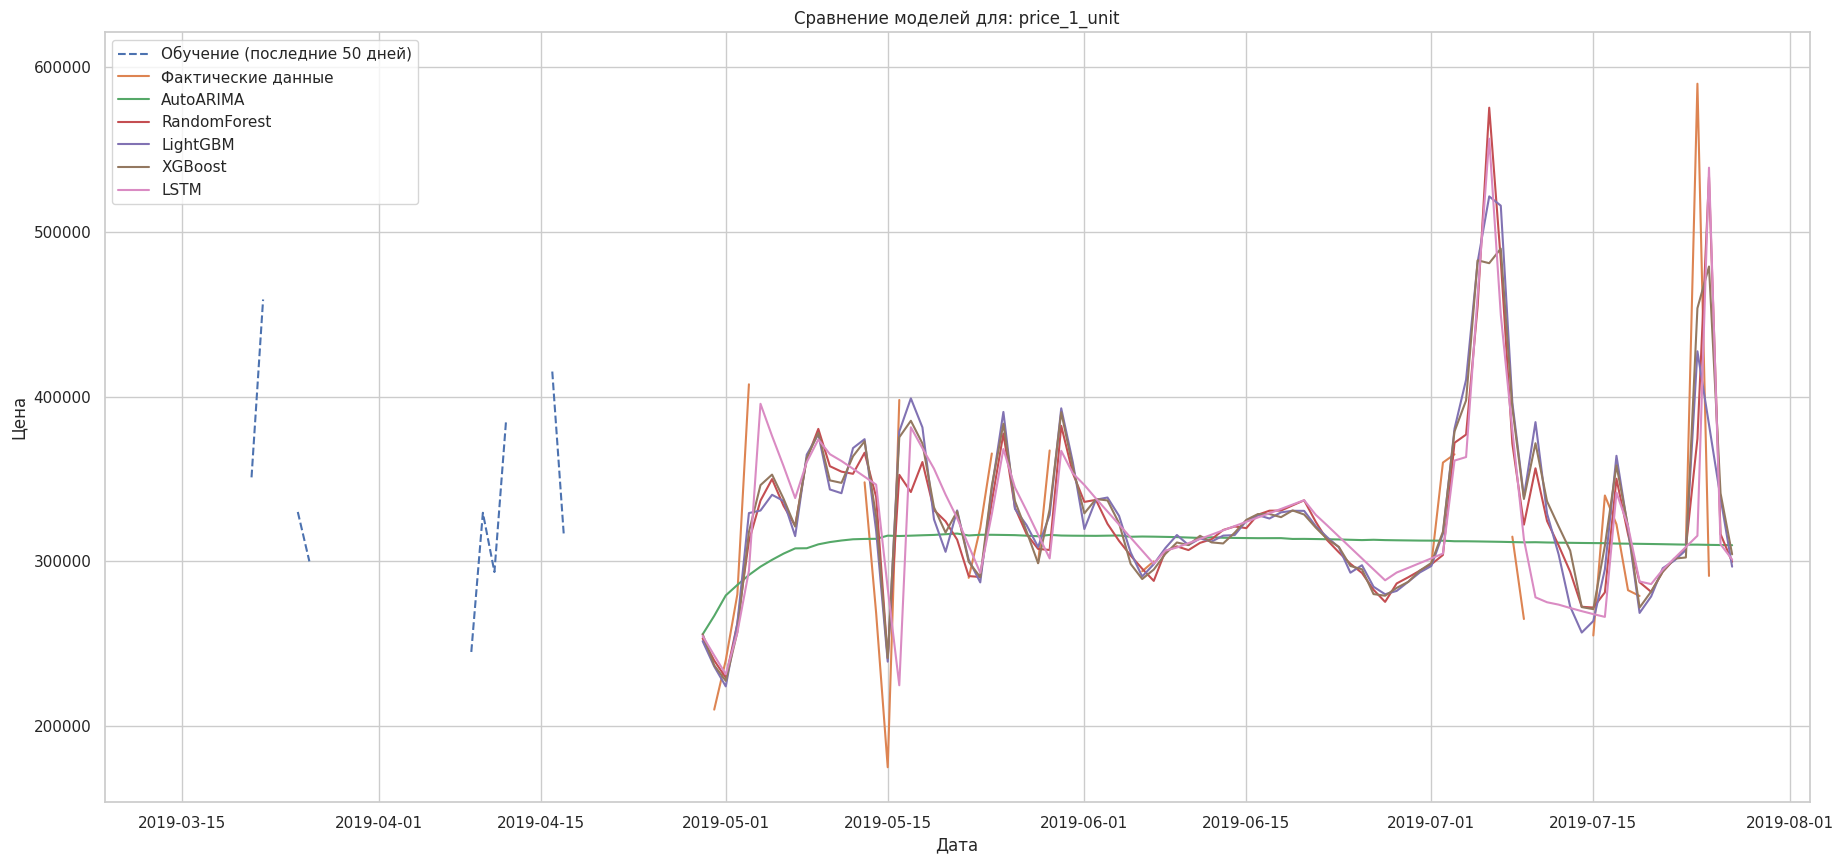

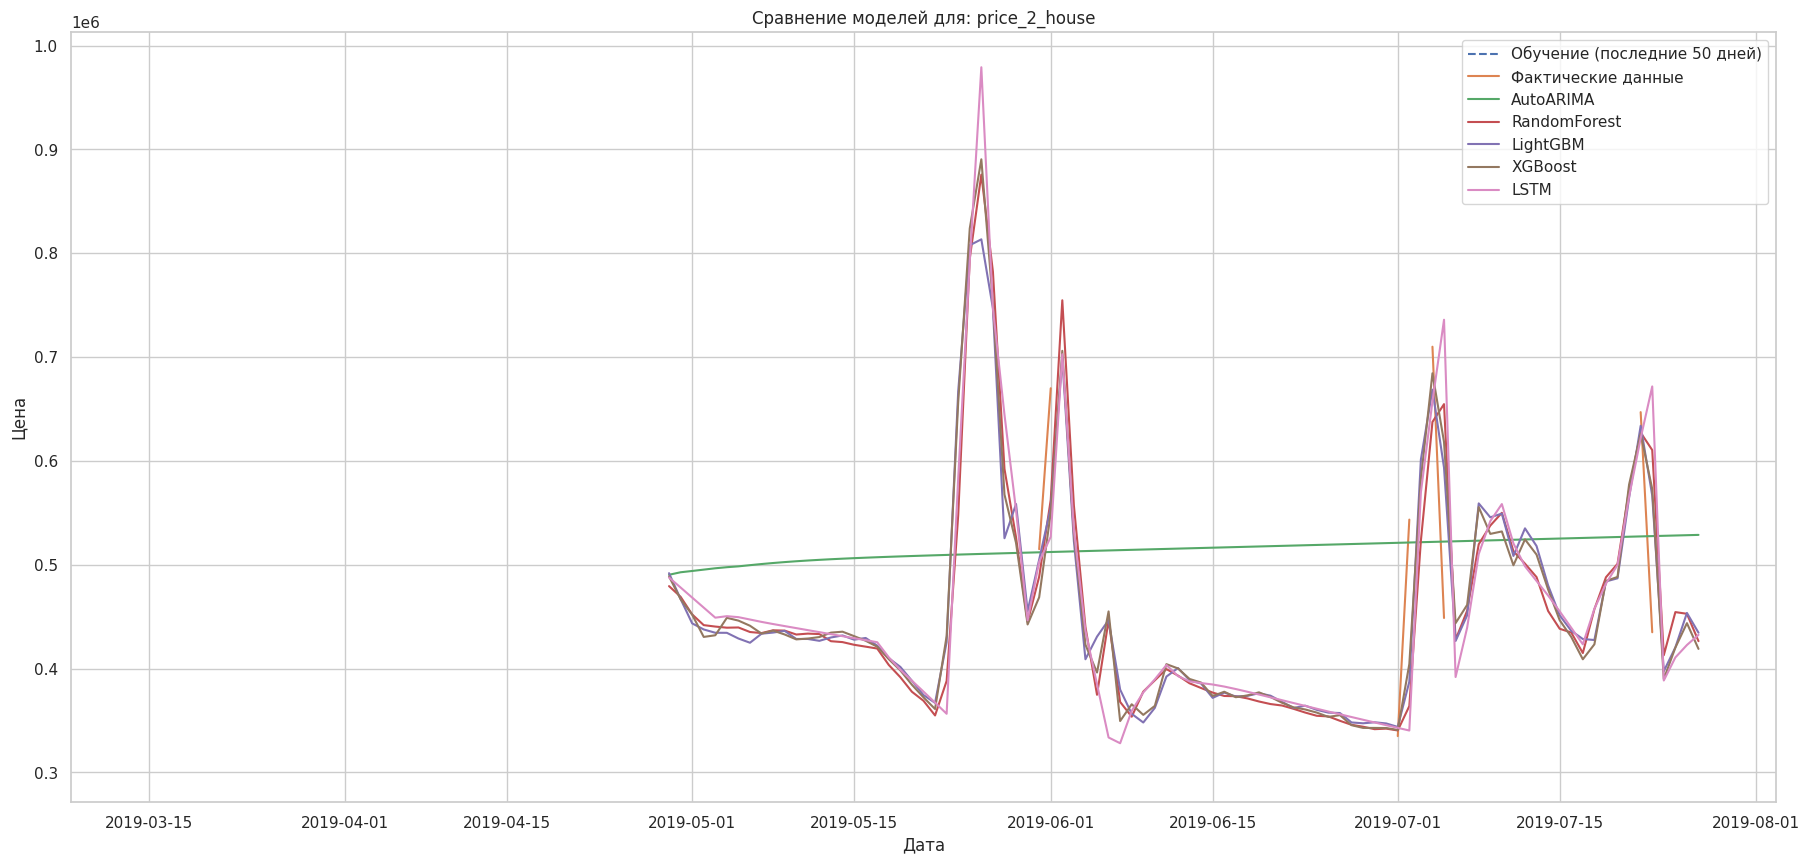

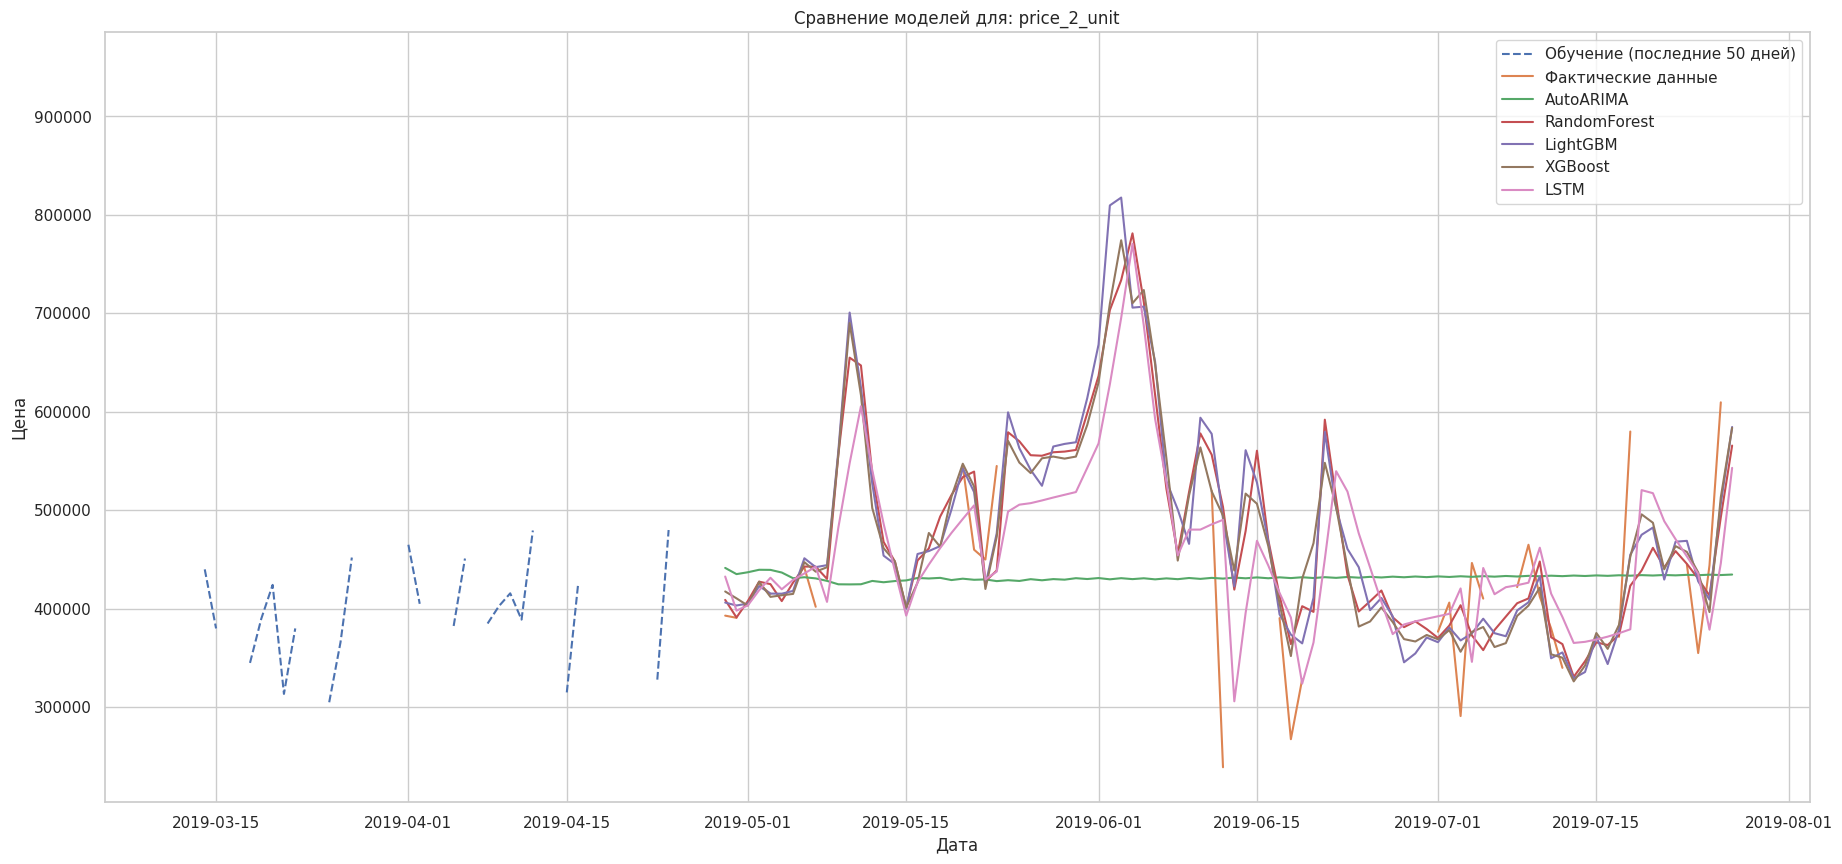

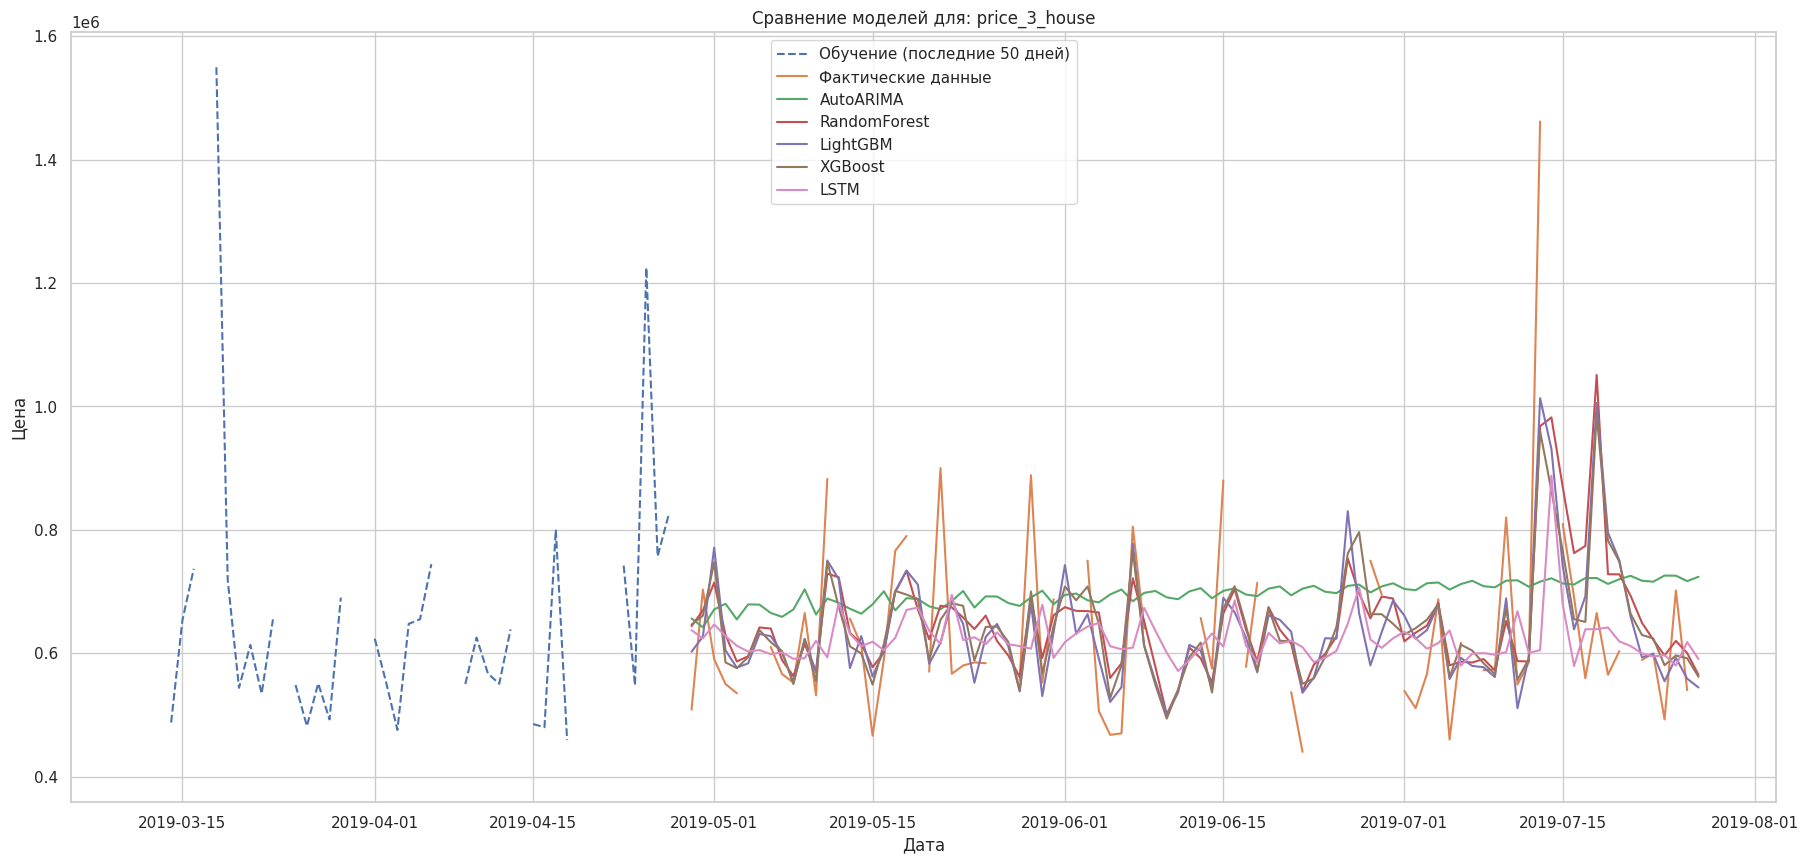

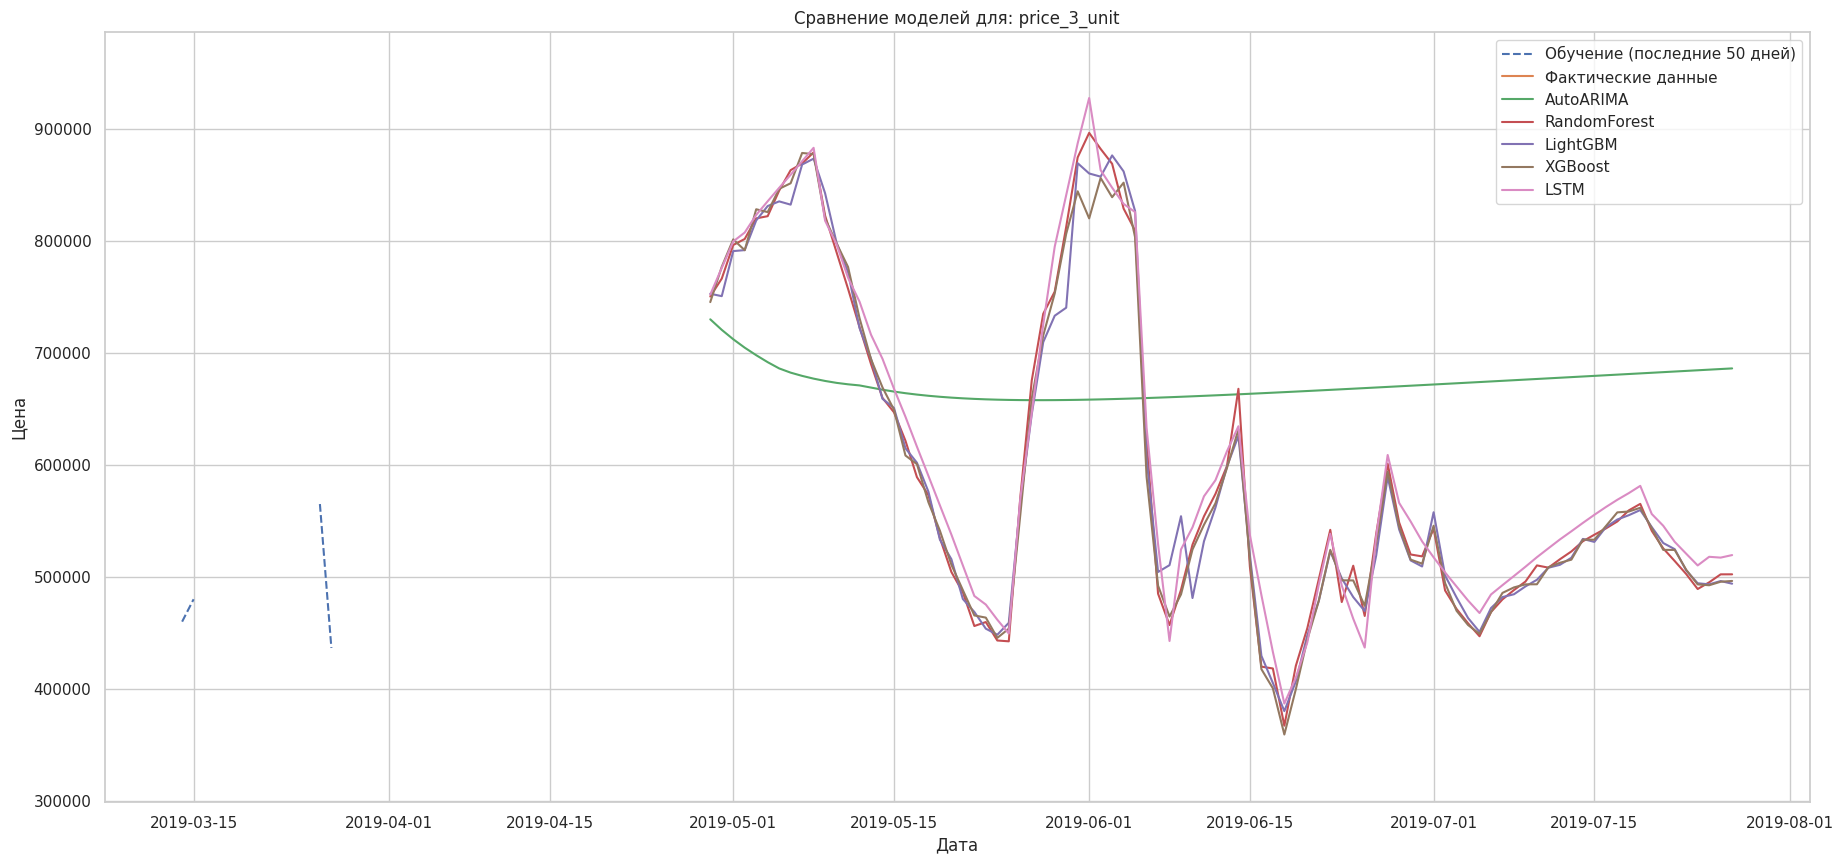

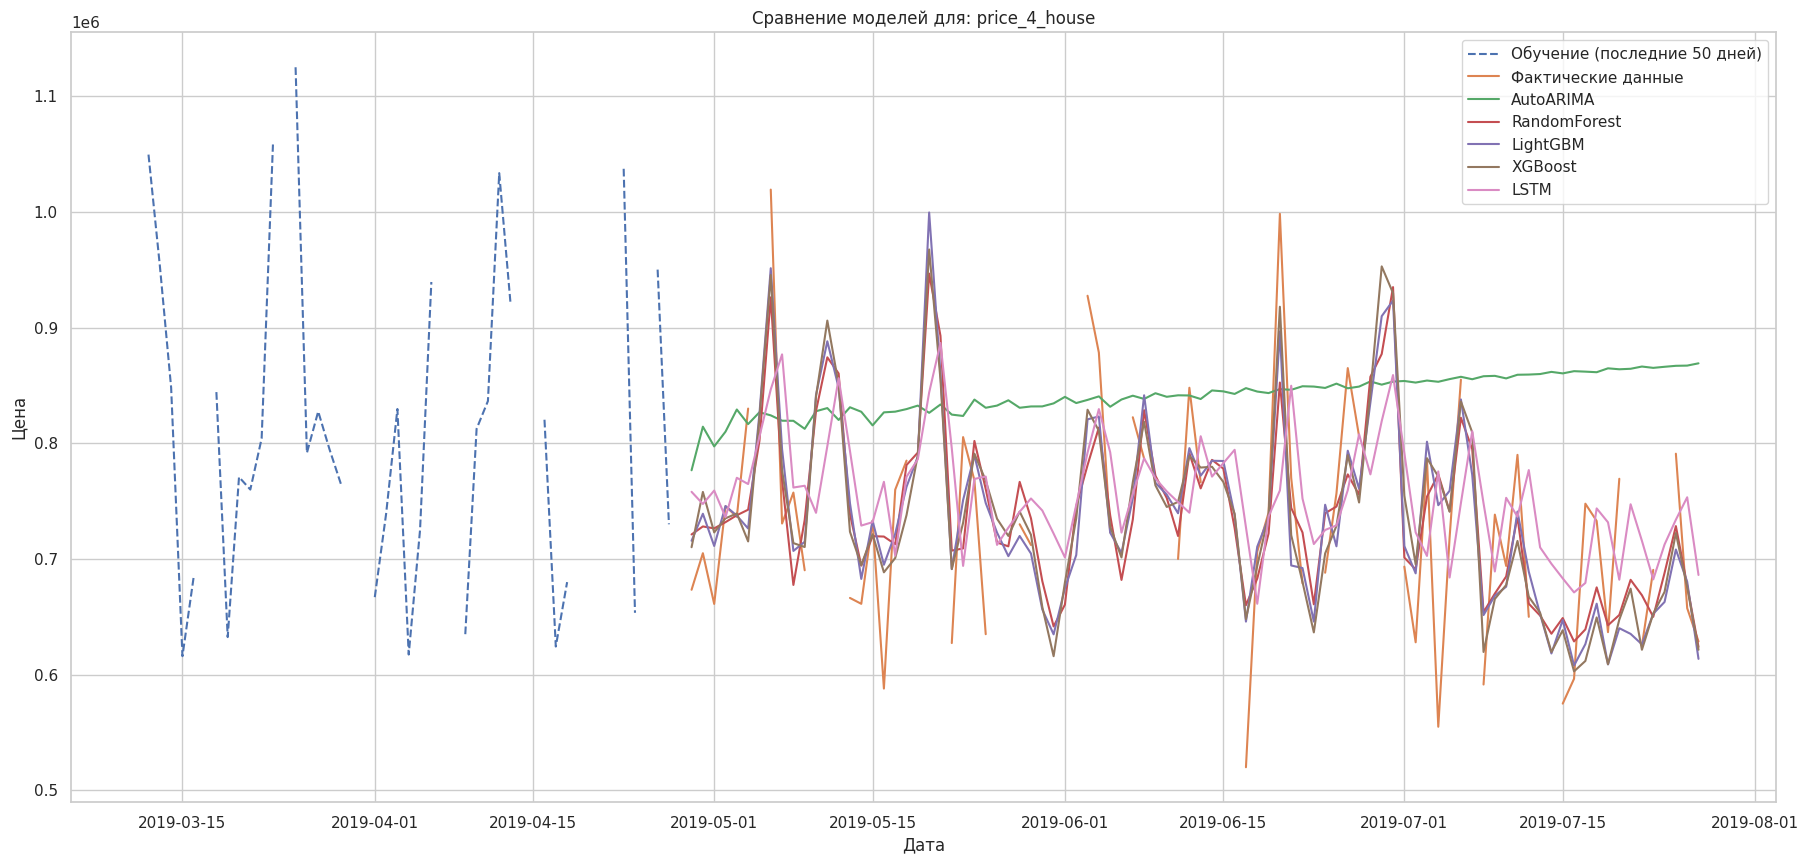

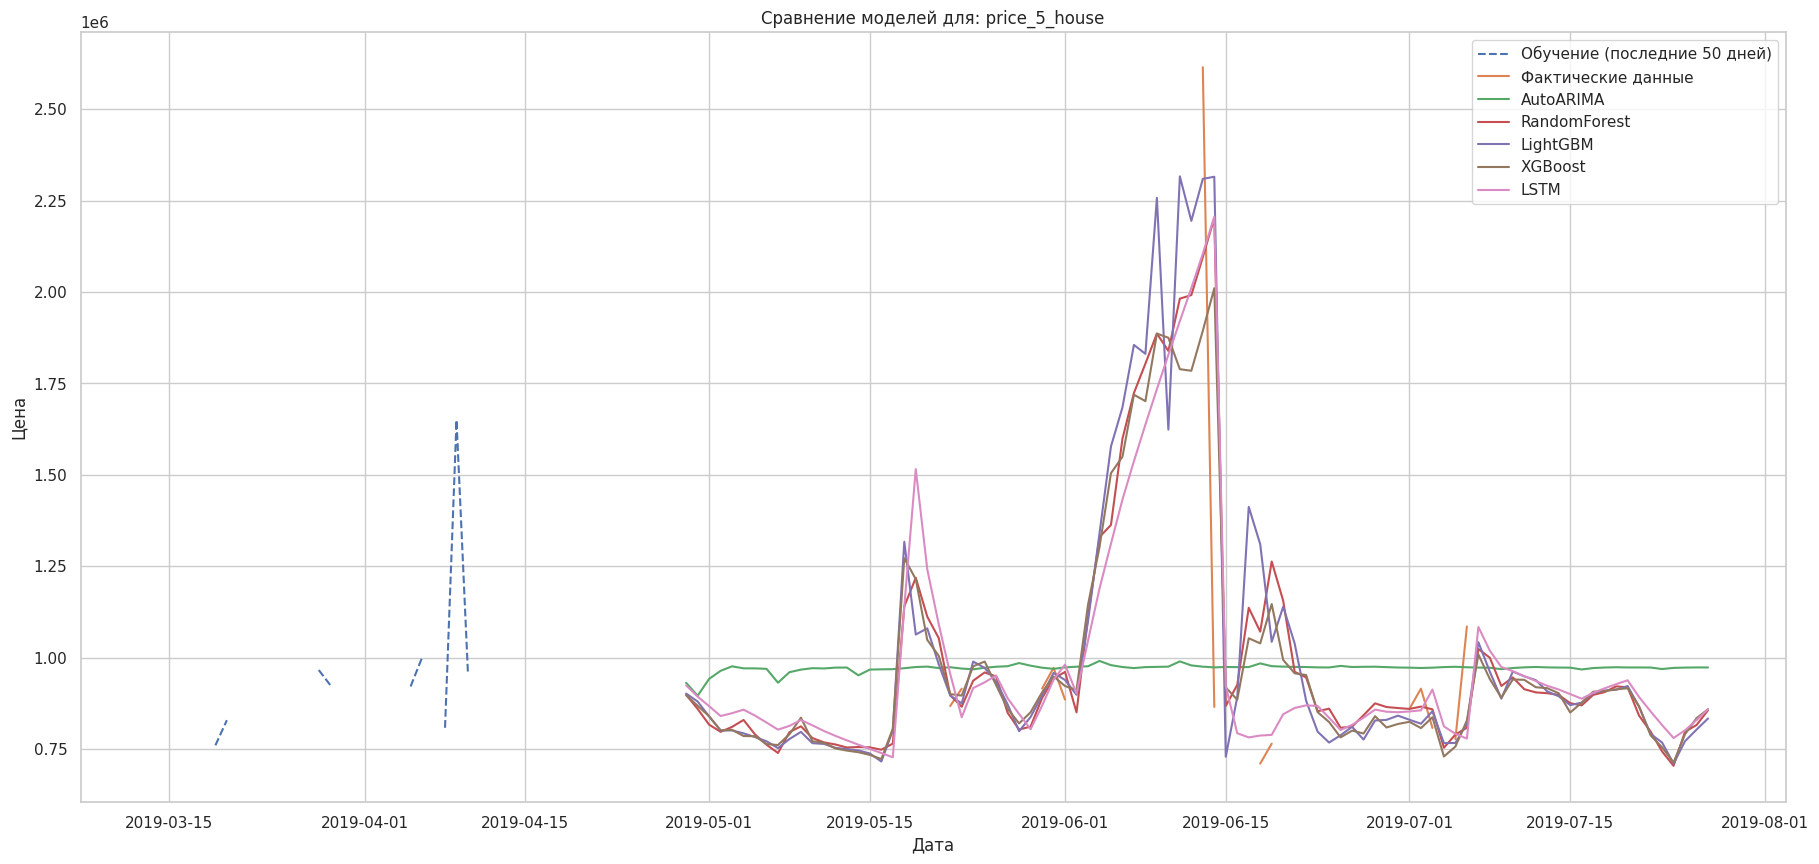

In [48]:
for col in all_ts_df.columns:
    if col == 'datesold':
        continue

    current_ts = all_ts_df.set_index("datesold")[col].asfreq("D")
    current_train = current_ts.iloc[:-horizon]
    current_test  = current_ts.iloc[-horizon:]

    plt.figure(figsize=(22, 10))
    plt.plot(current_train.tail(50), label="Обучение (последние 50 дней)", linestyle="--")
    plt.plot(current_test, label="Фактические данные")

    arima_pred_series = pd.read_csv(f'results/auto_arima_predictions/auto_arima_predictions_{col}.csv', index_col='datesold', parse_dates=True).squeeze()
    plt.plot(arima_pred_series, label="AutoARIMA")

    rf_pred_series = pd.read_csv(f'results/rf_predictions/rf_predictions_{col}.csv', index_col='datesold', parse_dates=True).squeeze()
    plt.plot(rf_pred_series, label="RandomForest")

    lgbm_pred_series = pd.read_csv(f'results/lgbm_predictions/lgbm_predictions_{col}.csv', index_col='datesold', parse_dates=True).squeeze()
    plt.plot(lgbm_pred_series, label="LightGBM")

    xgb_pred_series = pd.read_csv(f'results/xgb_predictions/xgb_predictions_{col}.csv', index_col='datesold', parse_dates=True).squeeze()
    plt.plot(xgb_pred_series, label="XGBoost")

    lstm_pred_series = pd.read_csv(f'results/lstm_predictions/lstm_predictions_{col}.csv', index_col='datesold', parse_dates=True).squeeze()
    plt.plot(lstm_pred_series, label="LSTM")

    plt.legend()
    plt.title(f"Сравнение моделей для: {col}")
    plt.xlabel("Дата")
    plt.ylabel("Цена")
    plt.grid(True)
    plt.savefig(f"images/all_models/prediction_{col}.png", dpi=200)
    plt.show()

*   **Общие наблюдения:**
    *   **Модели машинного обучения (RandomForest, LightGBM, XGBoost)** и **LSTM** в большинстве случаев гораздо лучше справляются с улавливанием общей динамики и трендов временных рядов по сравнению с **AutoARIMA**.
    *   **AutoARIMA** часто демонстрирует более гладкие, но менее точные прогнозы, особенно на пиках и спадах.
    *   Модели **LightGBM** и **XGBoost** часто дают очень похожие и высокоточные прогнозы.
    *   **RandomForest** также показывает хорошие результаты, схожие с градиентным бустингом, но иногда может быть чуть менее 'чувствительной' к резким изменениям.
    *   **LSTM** демонстрирует способность улавливать сложные паттерны, но иногда ее прогнозы могут отклоняться от основного тренда на длительных горизонтах, особенно в периоды, когда исходные данные имеют сильные колебания или пропуски в начале ряда.

*   **Примеры лучшего соответствия:**
    *   На графиках для `price_1_unit`, `price_2_house`, `price_3_house` и `price_4_house` прогнозы **LightGBM** и **XGBoost** визуально наиболее точно соответствуют фактическим данным, показывая минимальные отклонения и хорошо следуя изменениям цен.
    *   Для `price_3_unit` **RandomForest** визуально выглядит очень стабильно и близко к реальным значениям.
    *   Для `price_5_house` **LSTM** демонстрирует хорошую адаптацию к данным, подтверждая свои высокие метрики.

*   **Отклонения:**
    *   В некоторых случаях, например, для `price_5_house`, наблюдаются более значительные расхождения между прогнозами и фактическими данными, что может быть связано с большей сложностью или меньшим объемом данных.

В целом, графический анализ подтверждает количественные метрики, указывая на превосходство моделей машинного обучения и глубокого обучения над классической AutoARIMA для данной задачи прогнозирования цен на недвижимость.

# 7) Общие выводы по проекту

Основной целью данного проекта являлся поиск закономерностей и построение моделей для прогнозирования цен на жилье различных типов.

1. **Подготовка данных:**
- Данные были тщательно подготовлены, включая очистку, обработку пропусков методом интерполяции и формирование непрерывных временных рядов для различных категорий недвижимости, определяемых количеством спален и типом жилья (например, 'price_1_unit', 'price_2_house').

2. **Поиск закономерностей:**
- Исследовательский анализ данных выявил ключевые характеристики временных рядов: все они демонстрируют выраженный восходящий тренд и явную сезонность, при этом ряды с большим объемом данных (например, для домов с 3 спальнями) показывают более плавный тренд.
- Тесты стационарности (ADF, KPSS), а также анализ графиков автокорреляционных (ACF) и частичных автокорреляционных (PACF) функций, однозначно подтвердили нестационарность всех временных серий.
- Медленное убывание коэффициентов автокорреляции и значимые пики на первых нескольких лагах указывают на сильную зависимость текущей цены от ближайших прошлых значений, а наличие всплесков на лаге 7 для некоторых рядов (например, `price_3_house` и `price_4_house`) свидетельствует о недельной сезонности.

3. **Обучение моделей:**

- Для прогнозирования, данные были разделены на обучающую и тестовую выборки с горизонтом в 90 дней.
- Были обучены и оценены пять различных моделей: AutoARIMA, RandomForest Regressor, LightGBM Regressor, XGBoost Regressor и LSTM. Анализ времени обучения показал значительные различия в эффективности: модели градиентного бустинга (LightGBM — 13.44 секунды, XGBoost — 21.09 секунды) оказались наиболее быстрыми, в то время как RandomForest потребовал 4.17 минуты, LSTM — 25.60 минуты, а AutoARIMA была самой медленной, затратив 79.43 минуты.

4. **Определение лучшей модели:**

- Сравнительный анализ метрик ошибок (MAPE%, RMSE, MAE) выявил превосходство моделей машинного обучения и глубокого обучения над классической AutoARIMA. В частности, LightGBM показала наилучшие результаты для `price_1_unit` и `price_2_unit`. XGBoost продемонстрировала высокую точность для `price_2_house`, `price_3_house` и `price_4_house`. RandomForest оказалась лучшей для `price_3_unit`, а LSTM показала наилучшую производительность для `price_5_house'.
- Визуализация прогнозов подтвердила эти выводы: модели машинного обучения гораздо точнее улавливали общую динамику и тренды.
- На временных рядах с наибольшим количеством данных ( `price_3_house` и `price_4_house`) лучшей моделью оказалась XGBoost немного опередив LightGBM и RandomForest. При этом на рядах с наименьшим количеством данных( `price_2_house` и `price_3_unit`) лучшими оказались XGBoost и RandomForest.

В заключение, для задачи прогнозирования цен на недвижимость в данном проекте наиболее эффективными оказались модели машинного обучения с градиентным бустингом, а именно XGBoost, показав наименьшую ошибку в большинстве случаев и не требующую больших ресурсов и времени для прогнозирования.